In [1]:
import numpy as np
import torch as tr
import torch.nn as nn
from torch import distributions
from torch.nn.parameter import Parameter
import phi4_mg as m


#!/usr/local/bin/python3
import time
import numpy as np
import torch as tr
import phi4 as s
import integrators as i
import update as u

import matplotlib.pyplot as plt
from tqdm import tqdm

import argparse
import sys

import time
from stacked_model import *
import Gamma_error as gm

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import os
os.environ["PATH"] = "/sciclone/home/yacahuanamedra/texlive/bin/x86_64-linux:" + os.environ["PATH"]

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amsfonts}')
import pickle


from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

mpl.rc('font', **font)

## Discrete action

\begin{equation}
S[\phi] = \sum_{x} \left[ 
    \frac{1}{2} \tilde{m} \, \phi(x)^2 
    + \frac{\lambda}{24} \, \phi(x)^4 
    - \sum_{\mu=1}^{N_d} \phi(x) \, \phi(x + \hat{\mu}) 
\right]
\end{equation}

## Some observables

Phase in the code $\delta_n=e^{\frac{2i\pi}{L}n}$ with $p_n=\frac{2\pi}{L}n$

\begin{align}
\text{Field average or magnetization:} \quad
\langle \phi \rangle &= \frac{1}{V} \sum_x \phi(x) \\[8pt]
\text{Magnetic susceptibility:} \quad
\chi_m &= V \cdot \langle \phi \rangle^2 \\[8pt]
\text{Two-point correlator at momentum $p$}: \quad
C_2(p) &= V \cdot \left| \frac{1}{V} \sum_x \phi(x) \, e^{i p_n x} \right|^2 \\[8pt]
\text{Energy density:} \quad
E &= \frac{S[\phi]}{V}
\end{align}

In [ ]:


device = "cuda" if tr.cuda.is_available() else "cpu"
if(device=="cpu"):
    device = "mps" if tr.backends.mps.is_available() else "cpu"
# OK I will always use CPU for now
device = "cpu"
device = tr.device(device)
print(f"Using {device} device")

### Erase if not included in the  py files
def jackknife(d):
    # d is the list containing data
    # NOTE: it works with python lists not numpy arrays
    #
    N=len(d) -1 
    ss = sum(d)
    r=[]
    for n in range(len(d)):
        r.append((ss-d[n])/N)

    return r

def average(d):
    m = np.mean(d)
    e = np.std(d)/np.sqrt(len(d)-1)
    return m,e

def correlation_length(L,ChiM,C2p):
     return 1/(2*np.sin(np.pi/L))*np.sqrt(ChiM/C2p -1)

Using cpu device


## HMC loop

In [4]:
def get_observables_hist(sg,hmc, phi, Nwarm, Nmeas, Nskip,pp="no"):

    tic=time.perf_counter()
    Vol=sg.Vol
    lat=[phi.shape[1], phi.shape[2]]
    toc=time.perf_counter()

    print(f"time {(toc - tic)*1.0e6/Nwarm:0.4f} micro-seconds per HMC trajecrory")

    lC2p = []
    lchi_m = []
    E = []
    av_phi = []
    phase=tr.tensor(np.exp(1j*np.indices(tuple(lat))[0]*2*np.pi/lat[0]),dtype=sg.dtype,device=sg.device)
    for k in range(Nmeas):
        ttE = sg.action(phi)/Vol
        E.append(ttE)
        av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
        av_phi.append(av_sigma)
        chi_m = av_sigma*av_sigma*Vol
        p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
        C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
        if(k%100==0) and pp=="print":
            print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().numpy(),chi_m.mean().numpy(),C2p.mean().numpy(),ttE.mean().numpy())
            print("len(C2p): ", len(C2p))
        lC2p.append(C2p)
        lchi_m.append(chi_m)
        ## HMC update but also V cycle
        phi = hmc.evolve(phi,Nskip)

    return lC2p, lchi_m, E, av_phi, phi

def get_observables(lC2p, lchi_m, E, av_phi, phi):

    Vol=phi.shape[1]*phi.shape[2]
    lat=[phi.shape[1], phi.shape[2]]
    
    m_phi, e_phi = average(av_phi)
    print("m_phi: ",m_phi,e_phi)

    m_chi_m, e_chi_m = average(np.array(lchi_m) - (m_phi**2)*Vol)
    m_C2p, e_C2p     = average(lC2p)
    print(r"$\chi_m$: ",m_chi_m,'+/-', e_chi_m)
    print("C2p  : ",m_C2p,'+/-', e_C2p)
    avE,eE = average(E)
    print("E = ", avE ,'+/-',eE)

    xi = correlation_length(lat[0],m_chi_m, m_C2p)
    print("The correlation length is: ",xi)
    jphi   = np.array(jackknife(av_phi))
    jchi_m = np.array(jackknife(lchi_m)) - jphi**2 * Vol
    jC2p   = np.array(jackknife(lC2p))


    j_xi = correlation_length(lat[0],jchi_m,jC2p)

    m_xi,e_xi = average(j_xi)

    return m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi


def autocorrelation1(trace):
    #divide trace in 2
    trace=trace[0:trace.shape[0]]
    n=trace.shape[0]
    mean=tr.mean(trace)
    var=tr.var(trace)
    autocorr=tr.zeros_like(trace)
    for k in range(0,n-1):
        autocorr[k]=tr.sum((trace[0:n-k]-mean)*(trace[k:n]-mean))/(var*(n-k))
    return autocorr

    
def autocorrelation(trace):
    x = tr.as_tensor(trace, dtype=tr.float64)
    n = x.shape[0]
    x = x - x.mean()
    var = x.var(unbiased=False)
    acf = tr.zeros(n, dtype=x.dtype)
    for k in range(n):
        acf[k] = tr.dot(x[:n-k], x[k:]) / (var * (n - k))
    return acf # acf[0] == 1

#τ_int (Sokal: τ_int = 0.5 + sum_{t=1}^W ρ_t)
def integrated_autocorrelation_time(acf, max_lag=None):
    x = tr.as_tensor(acf, dtype=tr.float64)
    if x[0].abs().item() > 0:
        x = x / x[0]
    n = x.shape[0]
    if max_lag is None:
        W = 0
        for t in range(1, n):
            if (x[t] <= 0).item():
                break
            W = t
    else:
        W = min(int(max_lag), n - 1)
    return float(0.5 + x[1:W+1].sum().item())

def integrated_autocorrelation_time1(acf, max_lag=None):
    if max_lag is None:
        for t in range(1, len(acf)):
            if acf[t] < 0:
                max_lag = t
                break
        else:
            max_lag = len(acf) - 1
    return 0.5 + tr.sum(acf[1:max_lag])
def get_autocorrelationtime(av_phi, lchi_m):
    
    acf_phi = autocorrelation(tr.tensor(av_phi))
    #acf_phi = acf_phi / acf_phi[0]
    acf_suscept = autocorrelation(tr.tensor(lchi_m))
    max_lag=len(av_phi)//4
    print(acf_phi.shape)
    tau_int_phi = integrated_autocorrelation_time(acf_phi,max_lag)
    tau_int_suscept = integrated_autocorrelation_time(acf_suscept,max_lag)
    return tau_int_phi, tau_int_suscept

In [15]:
device = "cuda"
import integrators as i

mass_grid=np.linspace(-.58,-0.55,11)
L=32
lat = [L,L]
# This set of params is very very close to critical.
lam = 2.4
mas = -0.55
#
Nwarm = 100
Nmeas = 2000
Nskip = 1
batch_size = 10

Vol = np.prod(lat)
sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device,dtype=tr.float64)
phi = sg.coldStart()
#plot
#plt.imshow(phi[0].cpu().numpy())
#plt.show()

mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
hmc = u.hmc(T=sg,I=mn2,verbose=False)
phi = hmc.evolve(phi,1)
#plt.imshow(phi[0].cpu().numpy())
#plt.show()
lC2p, lchi_m, E, av_phi, phi = get_observables_hist(sg, hmc, phi, Nwarm, Nmeas, Nskip)

#tau_phi,tau_chi = get_autocorrelationtime(av_phi, lchi_m)
#m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([10, 32, 32]) 1024 tensor(1., device='cuda:0', dtype=torch.float64) tensor(0., device='cuda:0', dtype=torch.float64)
time 0.0958 micro-seconds per HMC trajecrory


### Gamma analysis for phi4 observables

In [ ]:
"""import torch as tr
tr.manual_seed(0)

N_total = 10000
obs = tr.exp(1.0 + 0.1 * tr.randn(N_total))  # A0 > 0
data = obs.unsqueeze(1)  # Shape [N, 1]
replicas =  tr.chunk(data, 5) # lista de 5 tensores [~2000, 1]
"""
rep_ten=tr.stack(av_phi).T.unsqueeze(2).to("cpu") #cpu
replicas = gm.split_first_dim_to_list(rep_ten)

print(tr.stack(replicas).shape, rep_ten.shape)

f = lambda A: A[0]
results = gm.gamma_method_with_replicas(replicas, f, max_lag=1000)
print(f"F = {results['value']:.6f} ± {results['dvalue']:.6f} (±{results['ddvalue']:.6f})")
print(f"tau_int = {results['tau_int']:.3f} ± {results['dtau_int']:.3f}")
print(f"W_opt = {results['W_opt']}, Q = {results['Q']}")


torch.Size([10, 2000, 1]) torch.Size([10, 2000, 1])
Optimal window found: W = 783
F = 0.024354 ± 0.174871 (±0.027026)
tau_int = 305.813 ± 94.524
W_opt = 783, Q = 0.0


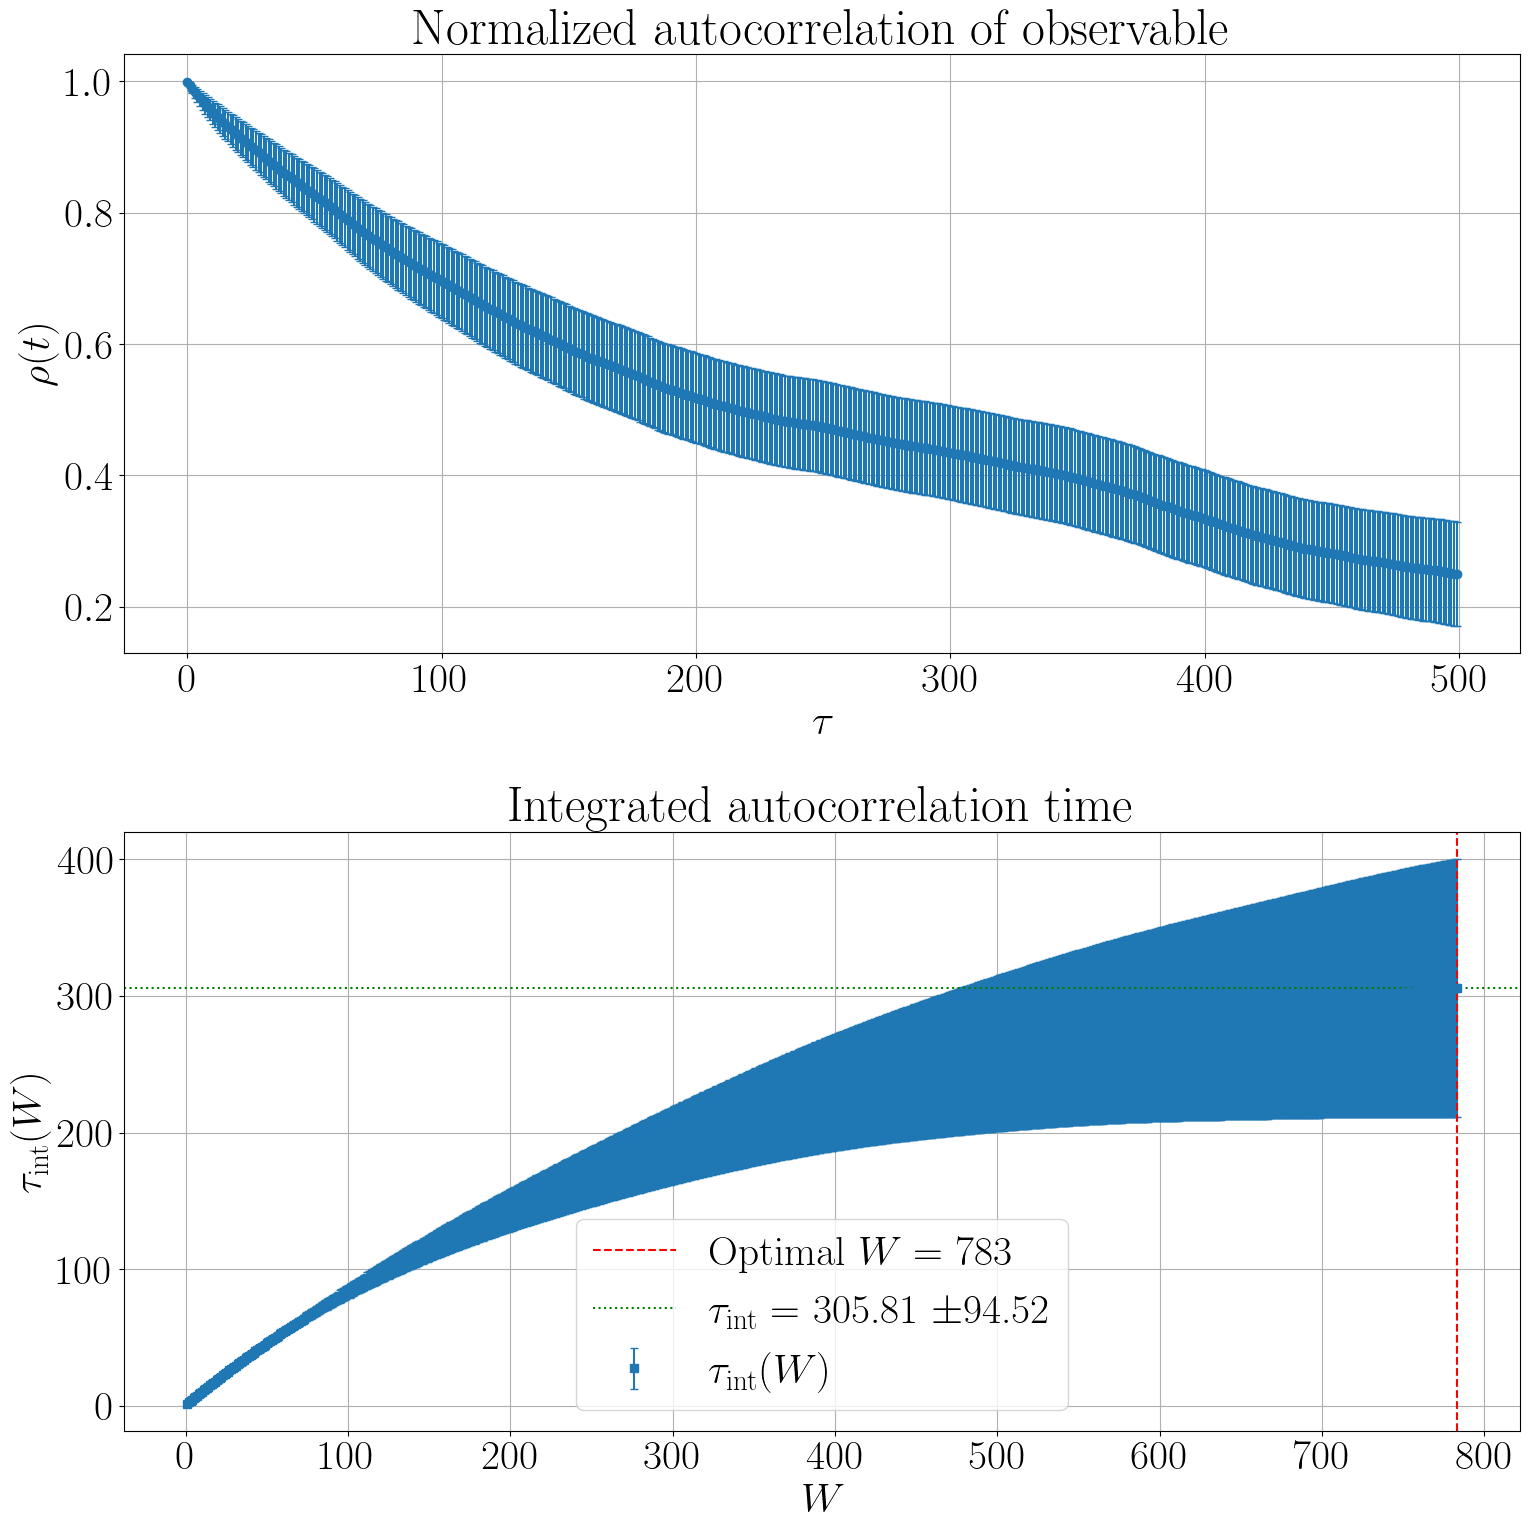

In [21]:
gm.plot_figure_2(results,max_lag=500)

### explore different masses

In [ ]:
mass_grid1=np.linspace(-.585,-0.54,6)
tau_phi1=np.zeros_like(mass_grid1)
tau_suscept1=np.zeros_like(mass_grid1)
dtau_phi1=np.zeros_like(mass_grid1)
dtau_suscept1=np.zeros_like(mass_grid1)
phi_av_mean=np.zeros_like(mass_grid1)
phi_av_std=np.zeros_like(mass_grid1)
sucept_mean=np.zeros_like(mass_grid1)
sucept_std=np.zeros_like(mass_grid1)
sss=0

for mas in mass_grid1:
    L=128
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 1000
    Nmeas = 10000
    Nskip = 1
    batch_size = 10

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)

    lC2p, lchi_m, E, av_phi, phi = get_observables_hist(sg, hmc, phi, Nwarm, Nmeas, Nskip)
    #tau_phi1[sss],tau_suscept1[sss] = get_autocorrelationtime(av_phi, lchi_m)
    results_av = gm.gamma_method_with_replicas(gm.split_first_dim_to_list(tr.stack(av_phi).T.unsqueeze(2)), lambda A: A[0], max_lag=2000)
    results_lchi = gm.gamma_method_with_replicas(gm.split_first_dim_to_list(tr.stack(lchi_m).T.unsqueeze(2)), lambda A: A[0], max_lag=2000)
    tau_phi1[sss]=results_av['tau_int']
    tau_suscept1[sss]=results_lchi['tau_int']
    dtau_phi1[sss]=results_av['dtau_int']
    dtau_suscept1[sss]=results_lchi['dtau_int']
    phi_av_mean[sss]=results_av['value']
    phi_av_std[sss]=results_av['dvalue']
    sucept_mean[sss]=results_lchi['value']
    sucept_std[sss]=results_lchi['dvalue']
    print("Gamma results for average phi:")
    print(f"F = {results_av['value']:.6f} ± {results_av['dvalue']:.6f} (±{results_av['ddvalue']:.6f})")
    print(f"tau_int = {results_av['tau_int']:.3f} ± {results_av['dtau_int']:.3f}")
    print(f"W_opt = {results_av['W_opt']}, Q = {results_av['Q']}")
    print("Gamma results for susceptibility:")
    print(f"F = {results_lchi['value']:.6f} ± {results_lchi['dvalue']:.6f} (±{results_lchi['ddvalue']:.6f})")
    print(f"tau_int = {results_lchi['tau_int']:.3f} ± {results_lchi['dtau_int']:.3f}")
    print(f"W_opt = {results_lchi['W_opt']}, Q = {results_lchi['Q']}")
    sss+=1
    #m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([10, 128, 128]) 16384 tensor(-0.0004) tensor(1.0029)
time 0.0029 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  -0.00037911406 0.78629816 0.8647147404731472 2.0191133
len(C2p):  10
k=  10 (av_phi,chi_m, c2p, E)  -0.002573313 2.3452122 1.6915237822540732 1.7450216
len(C2p):  10
k=  20 (av_phi,chi_m, c2p, E)  -0.008395276 6.3925557 9.325127743652287 1.5689653
len(C2p):  10
k=  30 (av_phi,chi_m, c2p, E)  -0.0030945528 6.0270004 8.227015305768283 1.3913428
len(C2p):  10
k=  40 (av_phi,chi_m, c2p, E)  -1.5505706e-05 11.215364 6.987836465239849 1.378331
len(C2p):  10
k=  50 (av_phi,chi_m, c2p, E)  0.0039354833 5.7863784 11.692733610230954 1.3748605
len(C2p):  10
k=  60 (av_phi,chi_m, c2p, E)  -0.006667075 13.544554 15.950416621219063 1.2649381
len(C2p):  10
k=  70 (av_phi,chi_m, c2p, E)  -0.022311589 36.942924 16.67057686812383 1.2174352
len(C2p):  10
k=  80 (av_phi,chi_m, c2p, E)  -0.031820994 53.758476 22.0439681689535 1.2122118
len(C2p):  10
k=  90 (av_phi,chi_m

### device

In [35]:
device = tr.device("cpu")
dev=1
# Check that MPS is available
if not tr.backends.mps.is_available():
    if not tr.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
     if (dev >= 0 ):
          device = tr.device("mps")

# Check that CUDA is available
if not tr.cuda.is_available():
    if not tr.backends.cuda.is_built():
        print("CUDA not available because the current PyTorch install was not "
              "built with CUDA enabled.")
    else:
        print("CUDA not available or you do not have a GPU on this machine.")

else:
     if (dev >= 0 ):
          device = tr.device("cuda:"+str(dev))


    
print(f"Using {device} device")

MPS not available because the current PyTorch install was not built with MPS enabled.
Using cuda:1 device


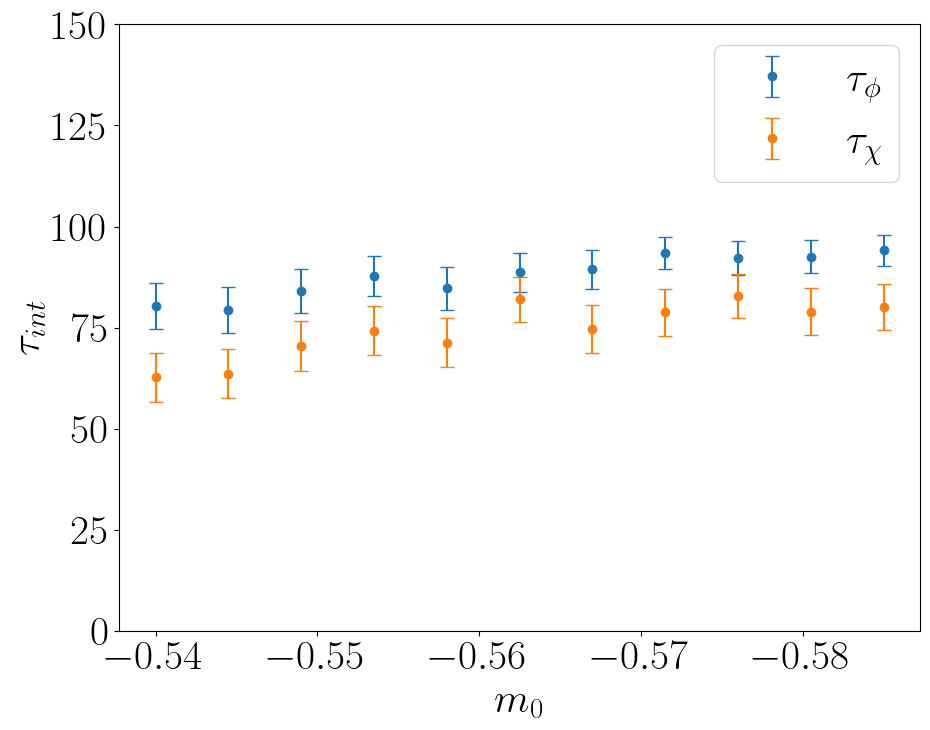

In [20]:
#plot mass vs tau
plt.figure(figsize=(10,8))
#reverse mass axis
plt.gca().invert_xaxis()
#plt.plot(mass_grid1,tau_phi1,'o-',label=r'$\tau_{\phi}$')
#plt.plot(mass_grid1,tau_suscept1,'o-',label=r'$\tau_{\chi}$')
#error bar format
plt.errorbar(mass_grid1,tau_phi1,yerr=dtau_phi1,fmt='o',label=r'$\tau_{\phi}$',capsize=5)
plt.errorbar(mass_grid1,tau_suscept1,yerr=dtau_suscept1,fmt='o',label=r'$\tau_{\chi}$',capsize=5)
plt.xlabel(r'$m_0$', fontsize=30)
plt.ylabel(r'$\tau_{int}$', fontsize=30)
plt.ylim(0,150)
#plt.yscale('log')
plt.legend(fontsize=30)

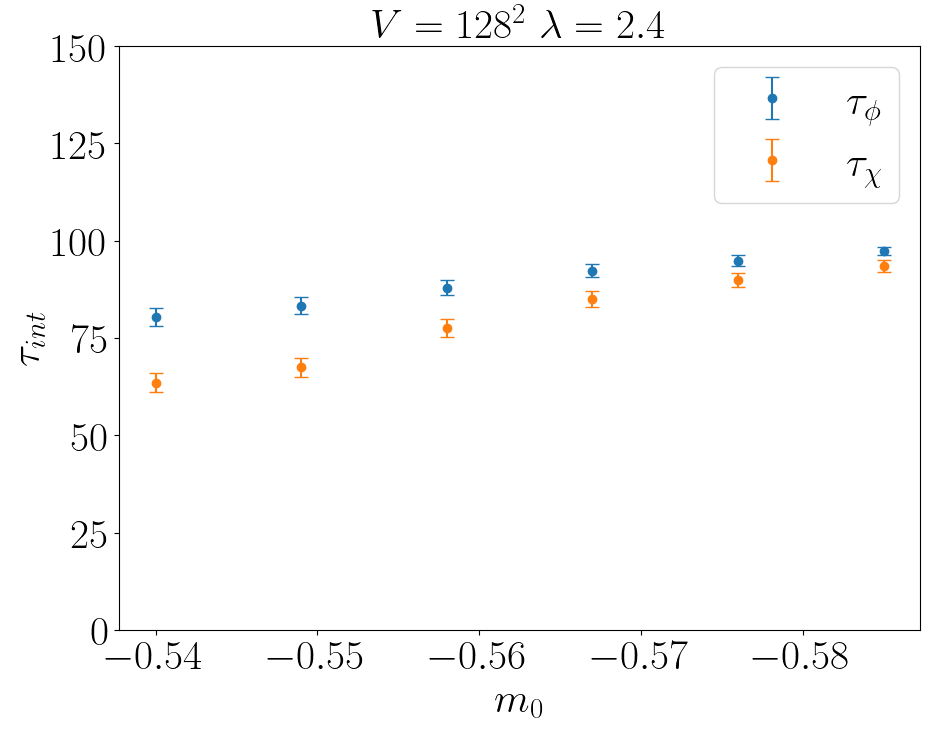

In [33]:
#plot mass vs tau
plt.figure(figsize=(10,8))
#reverse mass axis
plt.gca().invert_xaxis()
plt.title(r"$V=128^2$ $\lambda=2.4$", fontsize=30)
#plt.plot(mass_grid1,tau_phi1,'o-',label=r'$\tau_{\phi}$')
#plt.plot(mass_grid1,tau_suscept1,'o-',label=r'$\tau_{\chi}$')
plt.errorbar(mass_grid1,tau_phi1,yerr=dtau_phi1,fmt='o',label=r'$\tau_{\phi}$',capsize=5)
plt.errorbar(mass_grid1,tau_suscept1,yerr=dtau_suscept1,fmt='o',label=r'$\tau_{\chi}$',capsize=5)
plt.xlabel(r'$m_0$', fontsize=30)
plt.ylabel(r'$\tau_{int}$', fontsize=30)
#plt.yscale('log')
plt.ylim(0,150)
plt.legend(fontsize=30)

### Relations of meassurements

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


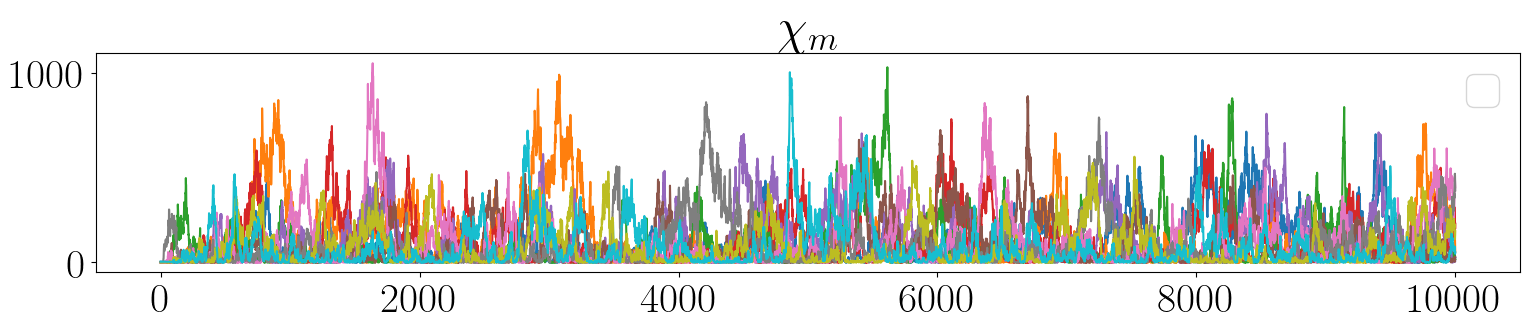

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


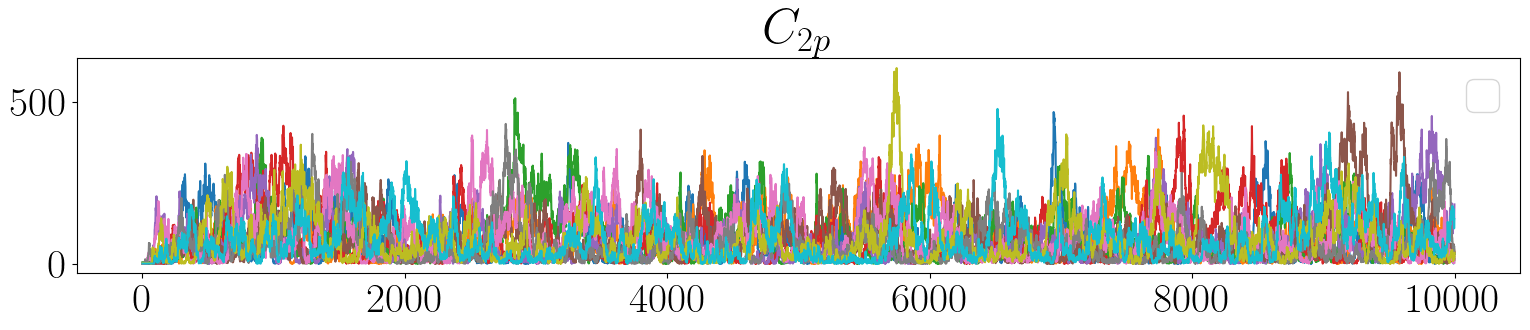

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


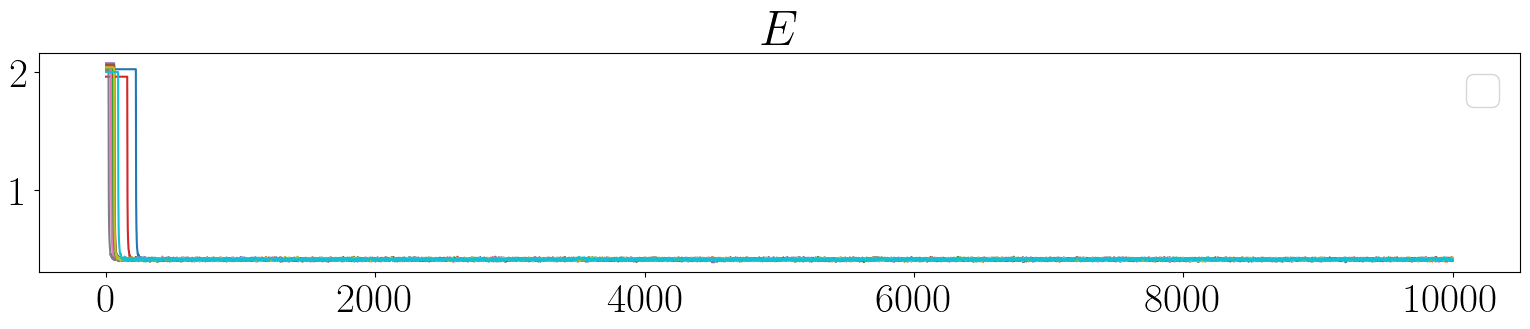

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1203599/1723070535.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


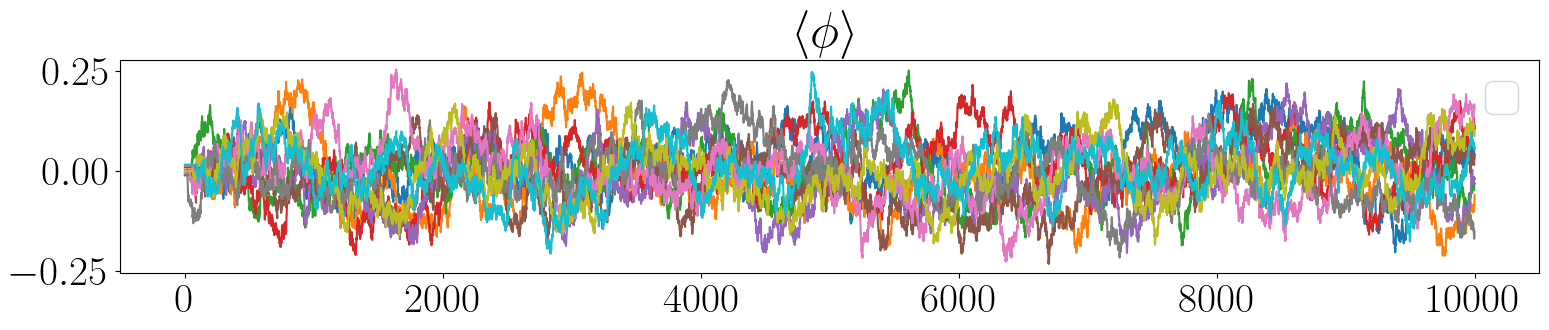

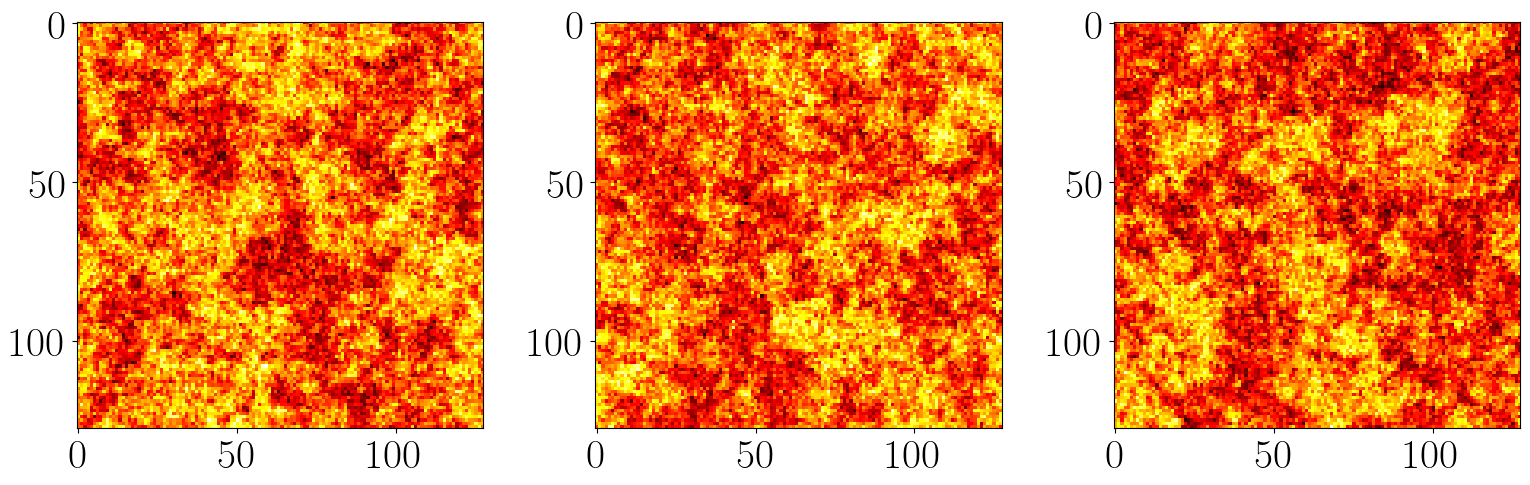

In [32]:

#size of the plot
plt.figure(figsize=(16, 4))
plt.title(r"$\chi_m$")
plt.plot(range(len(lchi_m)),lchi_m)#, label=r'$\chi_m$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$C_{2p}$")
plt.plot(range(len(lC2p)),lC2p)#, label=r'$C_{2p}$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$E$")
plt.plot(range(len(E)),E)#, label=r'$E$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$\langle \phi \rangle$")
plt.plot(range(len(av_phi)),av_phi)#, label=r'$\langle\phi\rangle$')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(16, 8))
for i in range(0,3):
    ax[i].imshow(phi[i,:,:], cmap='hot', interpolation='nearest')


# Autocorrelation time
Given the formula for autocorrelation time
$$C_X(t) = \frac{1}{(N - t) \cdot \sigma^2} \sum_{i=0}^{N-t-1} (X_i - \bar{X})(X_{i+t} - \bar{X})?$$

torch.Size([3000])
Integrated autocorrelation time for M: 209.80585245698467
Integrated autocorrelation time for chi_m: 164.6775212782384


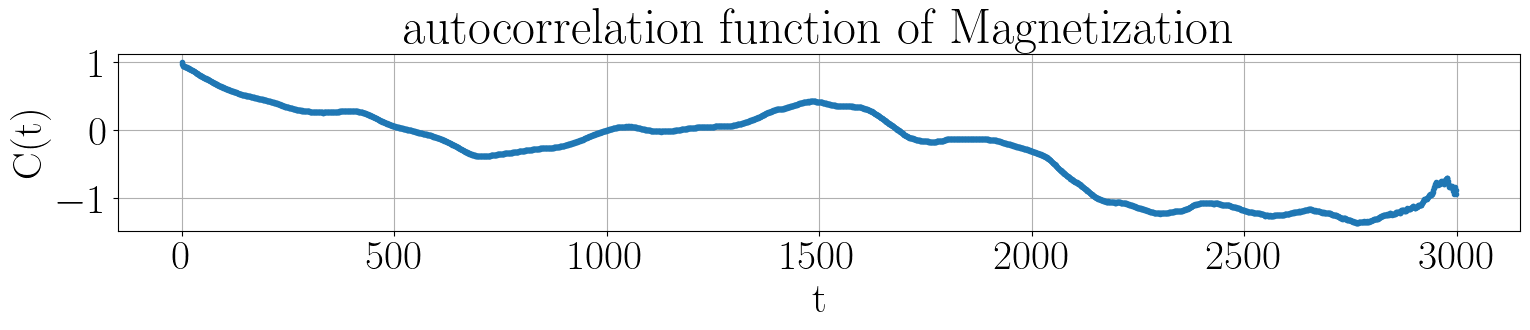

Text(0.5, 0, 't')

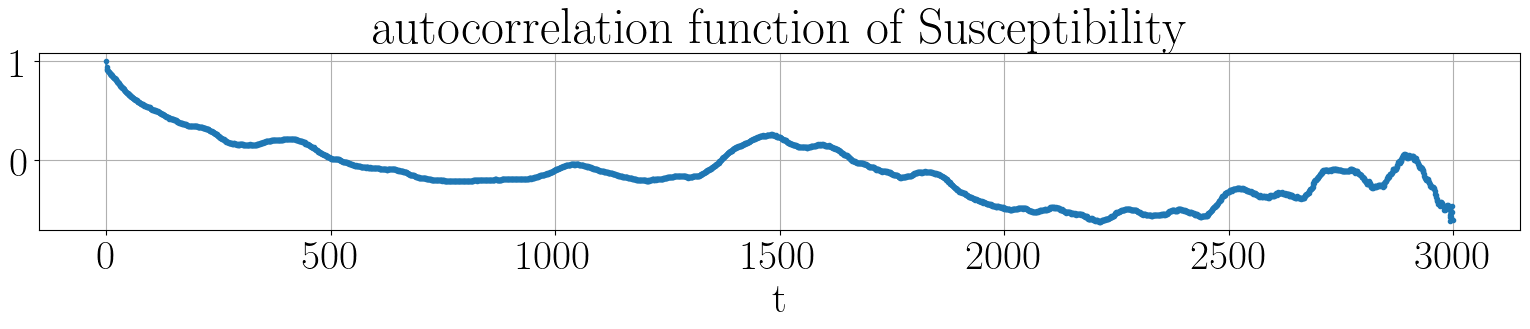

In [ ]:

acf_phi = autocorrelation(tr.tensor(av_phi))
#acf_phi = acf_phi / acf_phi[0]
acf_suscept = autocorrelation(tr.tensor(lchi_m))
print(acf_phi.shape)
tau_int_phi = integrated_autocorrelation_time(acf_phi,600)
tau_int_suscept = integrated_autocorrelation_time(acf_suscept,600)
print(f"Integrated autocorrelation time for M: {tau_int_phi}")
print(f"Integrated autocorrelation time for chi_m: {tau_int_suscept}")

plt.figure(figsize=(16, 4))
plt.plot(acf_phi[:5000], marker='.')
plt.title("autocorrelation function of Magnetization ")
plt.xlabel("t")
plt.ylabel("C(t)")
plt.grid(True)
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(acf_suscept[:5000], marker='.')
plt.title("autocorrelation function of Susceptibility ")
plt.grid(True)
plt.xlabel("t")

# Multigrid

### testing MCMG

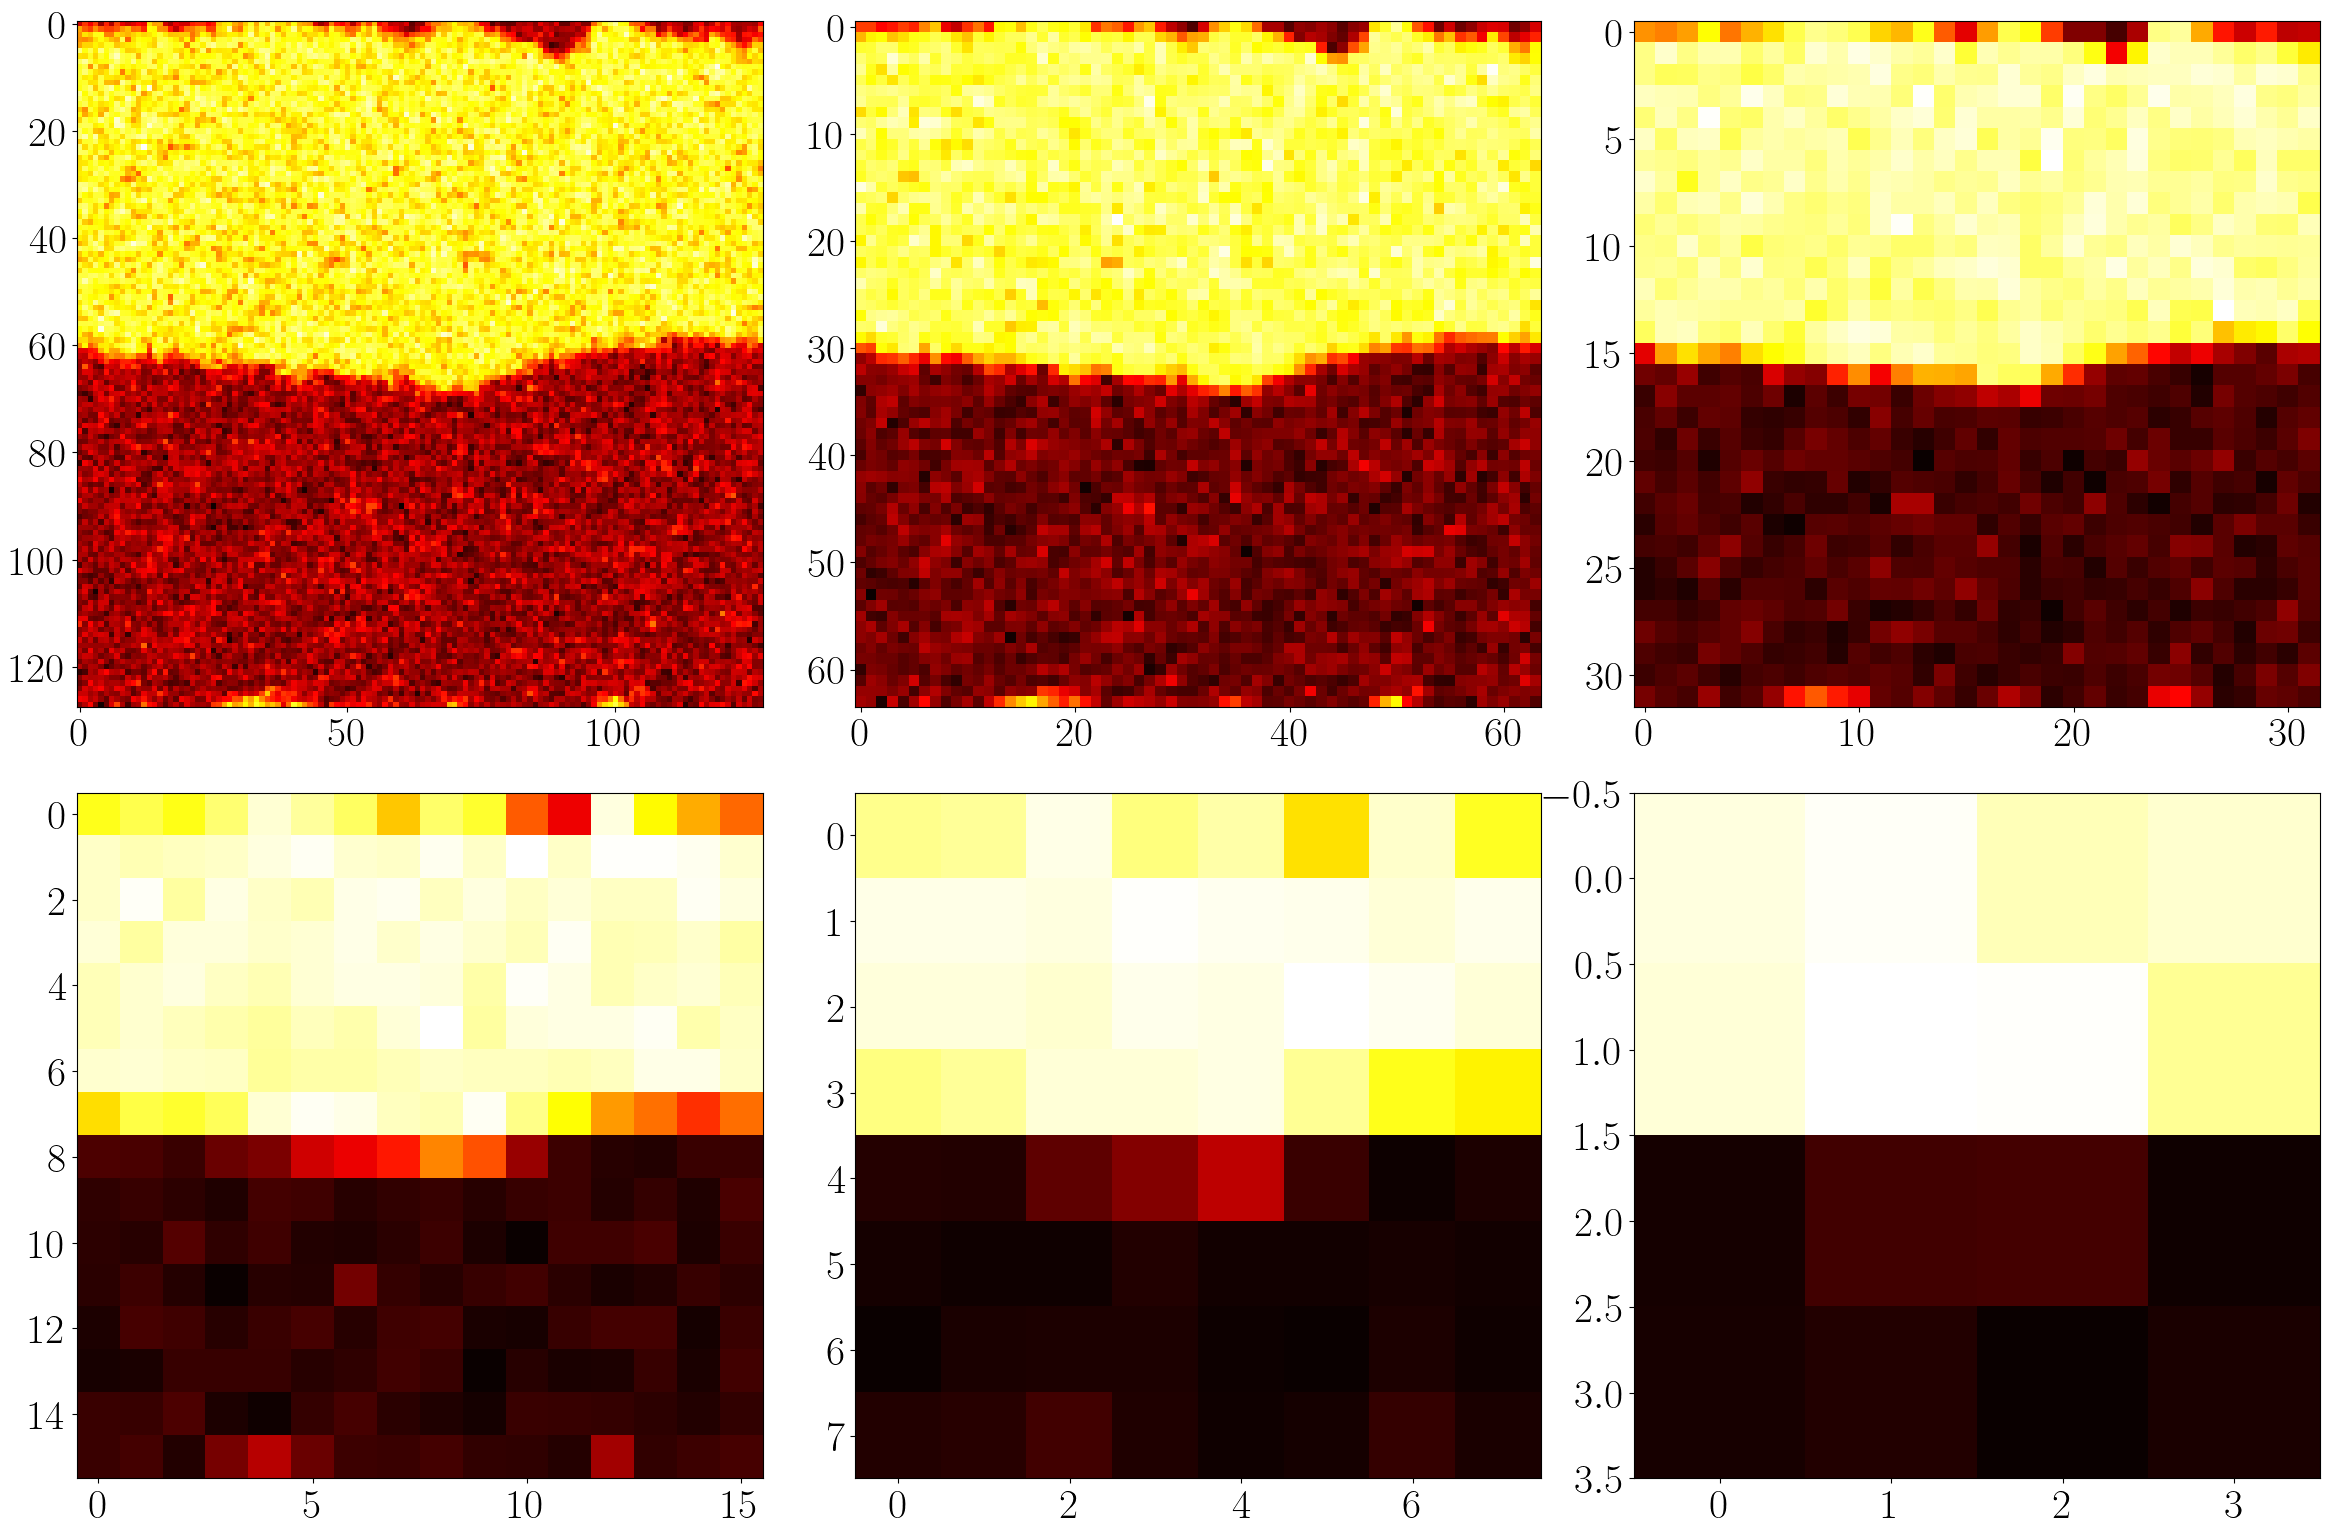

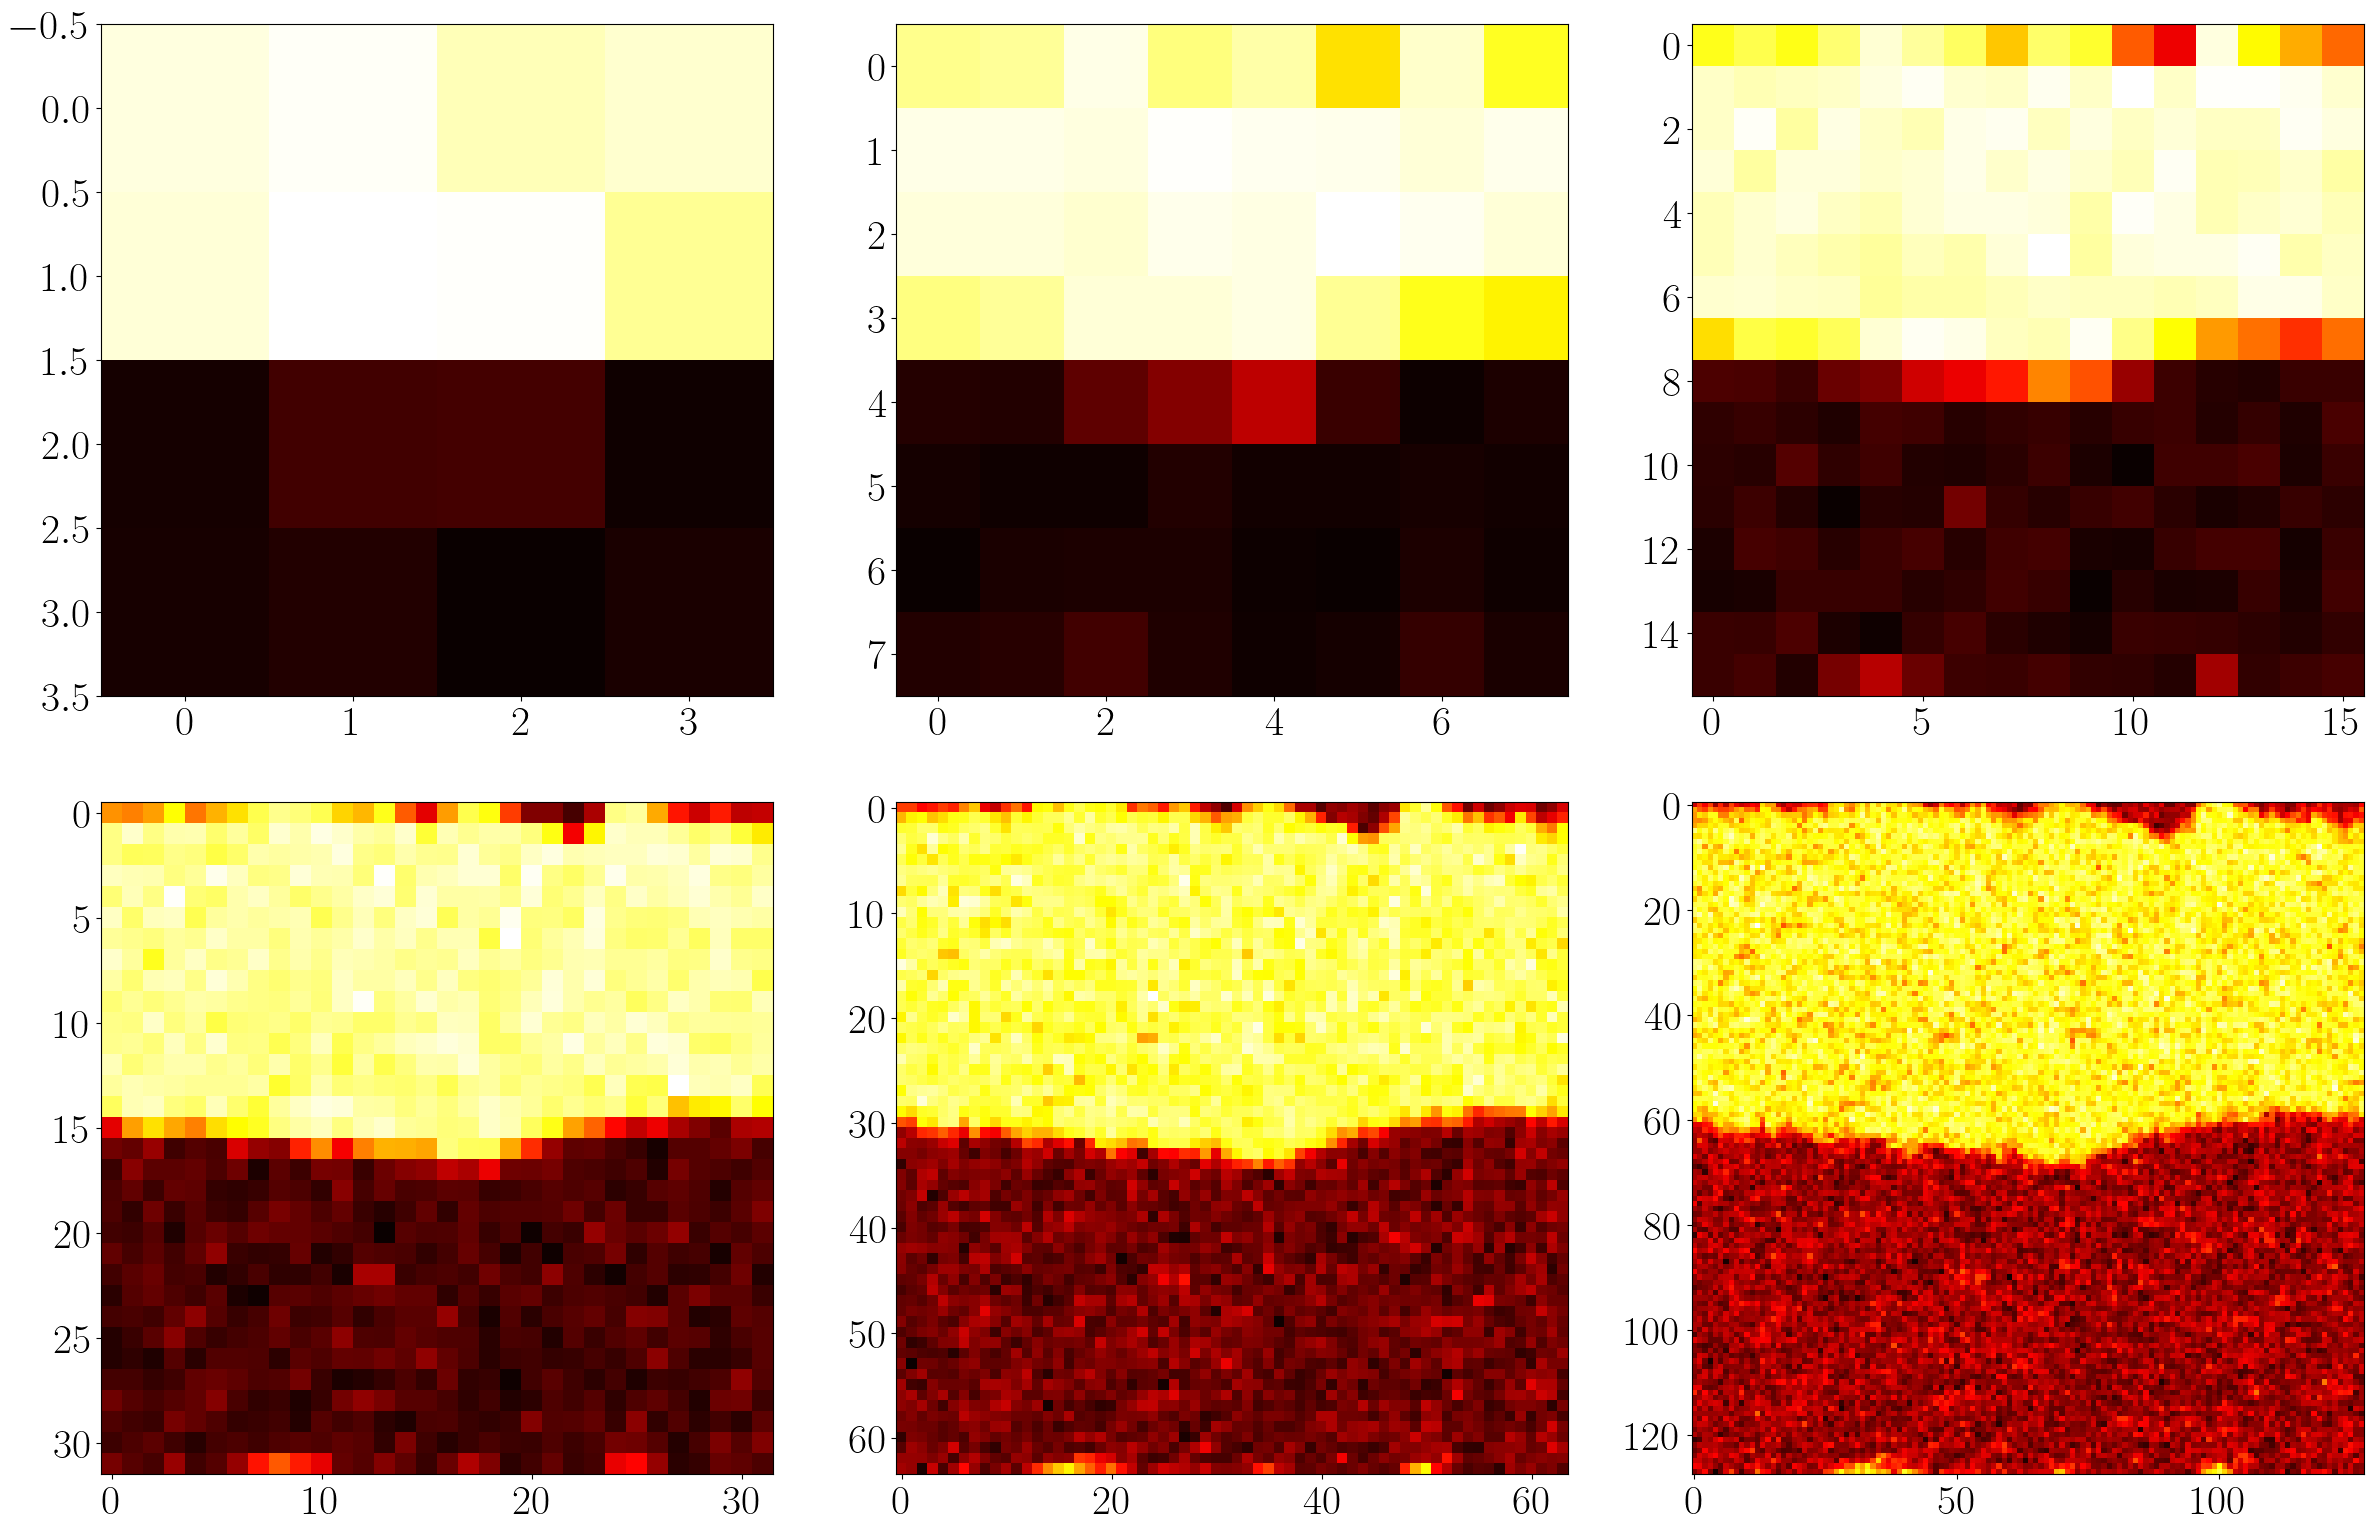

In [53]:
import phi4_mg as phimg
rg = phimg.RGlayer("average")
import integrators as i

phis=[]
pis=[]
phicopy=phi.clone()
phis.append(phi)
for _ in range(5):
    phic,pic = rg.coarsen(phicopy)
    phis.append(phic)
    pis.append(pic)
    phicopy=phic

#reversed
rphis=[]
rphis.append(phis[-1])
iii=0
for pics in reversed(pis):
    rphi = rg.refine(rphis[iii],pics)
    rphis.append(rphi)
    iii+=1

#plot the phi field
fig, ax = plt.subplots(2,3, figsize=(24, 16))
ax[0,0].imshow(phis[0][0,:,:], cmap='hot', interpolation='nearest')
ax[0,1].imshow(phis[1][0,:,:], cmap='hot', interpolation='nearest')
ax[0,2].imshow(phis[2][0,:,:], cmap='hot', interpolation='nearest')
ax[1,0].imshow(phis[3][0,:,:], cmap='hot', interpolation='nearest')
ax[1,1].imshow(phis[4][0,:,:], cmap='hot', interpolation='nearest')
ax[1,2].imshow(phis[5][0,:,:], cmap='hot', interpolation='nearest')
plt.show()
#one level up
fig, ax = plt.subplots(2,3, figsize=(24, 16))
ax[0,0].imshow(rphis[0][0,:,:], cmap='hot', interpolation='nearest')
ax[0,1].imshow(rphis[1][0,:,:], cmap='hot', interpolation='nearest')
ax[0,2].imshow(rphis[2][0,:,:], cmap='hot', interpolation='nearest')
ax[1,0].imshow(rphis[3][0,:,:], cmap='hot', interpolation='nearest')
ax[1,1].imshow(rphis[4][0,:,:], cmap='hot', interpolation='nearest')
ax[1,2].imshow(rphis[5][0,:,:], cmap='hot', interpolation='nearest')
#save figure
plt.savefig("rphis.pdf", bbox_inches='tight',dpi=300)
plt.show()
#one level down 

now we have to update the coarse field, and compare with any of the ml implementation in phi4_mg

### objects definition

In [3]:
import torch as tr
import torch.nn as nn

class RGlayer1(nn.Module):
    def __init__(self, transformation_type="select", batch_size=1, dtype=tr.float64, device="cpu"):
        super(RGlayer1, self).__init__()
        self.batch_size = batch_size
        self.dtype = dtype
        self.device = device

        if transformation_type == "select":
            mask_c = [[1.0, 0.0], [0.0, 0.0]]
            mask_r = [[1.0, 1.0], [1.0, 1.0]]
        elif transformation_type == "average":
            mask_c = [[0.25, 0.25], [0.25, 0.25]]
            mask_r = [[1.0, 1.0], [1.0, 1.0]]
        else:
            print("Unknown RG blocking transformation. Using default.")
            mask_c = [[1.0, 0.0], [0.0, 0.0]]
            mask_r = [[1.0, 0.0], [0.0, 0.0]]

        self.type = transformation_type

        self.restrict = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2, 2), stride=2, bias=False)
        self.restrict.weight = nn.Parameter(tr.tensor([[mask_c]], dtype=self.dtype, device=self.device), requires_grad=False)
        self.prolong = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=(2, 2), stride=2, bias=False)
        self.prolong.weight = nn.Parameter(tr.tensor([[mask_r]], dtype=self.dtype, device=self.device), requires_grad=False)

    def coarsen(self, f):
        #print("coarsen device: ", f.device, f.dtype)
        ff = f.view(f.shape[0], 1, f.shape[1], f.shape[2])
        c = self.restrict(ff)
        r = ff - self.prolong(c)
        return (c.squeeze(1), r.squeeze(1)) if self.batch_size == 1 else (c.squeeze(), r.squeeze())

    def refine(self, c, r):
        cc = c.view(c.shape[0], 1, c.shape[1], c.shape[2])
        rr = r.view(r.shape[0], 1, r.shape[1], r.shape[2])
        return (self.prolong(cc) + rr).squeeze(1) if self.batch_size == 1 else (self.prolong(cc) + rr).squeeze()
    


In [64]:
class RGlayer(nn.Module):
    def __init__(self,transformation_type="select",batch_size=1):
        super(RGlayer, self).__init__()
        self.batch_size = batch_size
        if(transformation_type=="select"):
            mask_c = [[1.0,0.0],[0.0,0.0]]
            mask_r = [[1.0,1.0],[1.0,1.0]]
        elif(transformation_type=="average"):
            mask_c = [[0.25,0.25],[0.25,0.25]]
            mask_r = [[1.00,1.00],[1.00,1.00]]
        else:
            print("Uknown RG blocking transformation. Using default.")
            mask_c = [[1.0,0.0],[0.0,0.0]]
            mask_r = [[1.0,0.0],[0.0,0.0]]
                  
        # We need this for debuging
        self.type = transformation_type
        
        self.restrict = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(2,2),stride=2,bias=False)
        self.restrict.weight = tr.nn.Parameter(tr.tensor([[mask_c]]),requires_grad=False)

        self.prolong = nn.ConvTranspose2d(in_channels=1,out_channels=1,kernel_size=(2,2),stride=2,bias=False)
        self.prolong.weight = tr.nn.Parameter(tr.tensor([[mask_r]]),requires_grad=False)

        
    def coarsen(self,f):
        #print(f.shape)
        ff = f.view(f.shape[0],1,f.shape[1],f.shape[2])
        c = self.restrict(ff)
        r = ff-self.prolong(c)
        #print(c.shape,r.shape,"c and r shapes")
        if self.batch_size==1:
            return c.squeeze(1),r.squeeze(1)
        else:
            return c.squeeze(),r.squeeze()
    
    def refine(self,c,r):
        #print(c.shape,r.shape,"c and r shapes in refine")
        cc = c.view(c.shape[0],1,c.shape[1],c.shape[2])
        rr = r.view(c.shape[0],1,r.shape[1],r.shape[2])
        #print(cc.shape,rr.shape,"cc and rr shapes in refine")
        if self.batch_size==1:
            return (self.prolong(cc)+rr).squeeze(1)
        else:
            return (self.prolong(cc)+rr).squeeze()

In [144]:
class phi4_c1:
    def action(self,phi_c):
        rphis=[]
        rphis.append(phi_c)
        iii=0
        logdet_total=tr.zeros(phi_c.shape[0],dtype=self.dtype,device=self.device)
        for pi in reversed(self.pics):
            #print(pi.shape)
            rphi = self.rg.refine(rphis[iii],pi)
            if self.mode=="rnvp":
                #flowback through the network
                #rphi,logdet = self.mgf.cflow[self.level-1-iii].backward(rphi)
                #logdet_total+=logdet
                rphi = self.mgf.cflow[self.level-1-iii].forward(rphi)
                logdet_total+=self.mgf.cflow[self.level-1-iii].log_prob(rphi)
            #print("log_det",logdet,"level",self.level-1-iii)
            rphis.append(rphi)
            iii+=1
        #phi_f = rphis[-1]
        #evaluate coarse field in action of rg
        #print(phi_f.shape,"shape of fine field")
        return self.sg.action(rphi)+logdet_total ## NANs
        #if I dont add the .sum() I got a grad for the batch system, it seems to me that we include that in the force property the batch is summed?

    def force(self, phi_c):
        x_tensor = phi_c.clone().requires_grad_()

        S = self.action(x_tensor)
        grad = tr.autograd.grad(S.sum(), x_tensor, retain_graph=False)[0]

        if grad is None:
            print("[ERROR] Gradient is None.")
            raise RuntimeError("autograd.grad returned None.")
        #release memory on gpu
        return -grad.detach()
    
    def refreshP(self):
        P = tr.normal(0.0,1.0,self.phis[-1].shape).to(self.device).to(self.dtype)#only difference with fine level
        return P

    def evolveQ(self,dt,P,Q):
        return Q + dt*P
    
    def kinetic(self,P):
        return tr.einsum('bxy,bxy->b',P,P)/2.0

    def generate_cfg_levels(self,phi11):#run every time we need to contruct deeper or superficial levels
        #run a configuration
        self.level = self.mgf.depth
        phis=[]
        pis=[]
        phicopy=phi11.clone().to(self.device).to(self.dtype)
        
        #print("shape of the original field",phicopy.shape)
        phis.append(phicopy)
        for step in range(self.level):
            if self.mode=="rnvp":
                phicopy= self.mgf.cflow[step].forward(phicopy)
                #print("device phicopy ",phicopy.device," dtype ",phicopy.dtype)
            #print("coarsening level ",_," field shape ",phicopy.shape)
            phic,pic = self.rg.coarsen(phicopy)

            phis.append(phic)
            pis.append(pic)
            phicopy=phic
        self.phis=phis
        self.pics=pis

        #reversed
        rphis=[]
        
        rphis.append(phis[-1])
        #self.mgf.cflow[step].backward(rphis[0])
        sss=0
        for phics,pis in zip(reversed(phis),reversed(pis)):
            
            rphi = self.rg.refine(phics,pis)
            #flowback through the network
            if self.mode=="rnvp":
                rphi,logdet = self.mgf.cflow[self.level-1-sss].backward(rphi)
                #print("log_det",logdet,"level",self.level-1-sss)
            sss+=1
            
            rphis.append(rphi)
        self.rphis=rphis

    def __init__(self,sgg,mgf,device="cpu",dtype=tr.float64,mode="rnvp"):
        self.sg = sgg #theory? in the finest level
        self.mgf = mgf #neural net
        self.rg = mgf.rg #projector to coarse level
        self.mode = mode
        print("multigrid is done by: ",self.mode)
        self.device = device
        self.dtype = dtype


In [145]:
class MGflow1(nn.Module):
    def __init__(self,size,bijector,rg,prior,Nconvs=1,depth=None):
        super(MGflow1, self).__init__()
        self.prior=prior
        self.rg=rg
        self.size = size
        minSize = min(size)
        print("Initializing MGflow module with size: ",minSize)
        if depth==None:
            self.depth = int(np.log(minSize)/np.log(2))
        else:
            self.depth = depth
        print("Using depth: ", self.depth)
        print("Using rg type: ",rg.type)
        sizes = []
        for k in range(self.depth):
            sizes.append([int(size[i]/(2**k)) for i in range(len(size))])
            print("(depth, size): ", k, sizes[-1])
            
            
        # the module list are ordered from fine to coarse
        self.cflow=tr.nn.ModuleList([m.ConvFlowLayer(sizes[k],bijector,Nconvs) for k in range(self.depth)])

    #noise to fields
    def forward(self,z):
        x = z
        
        # can I use lists and still expect autgrad to work?
        fines = []
        #take the noise to the coarsest level
        for k in range(self.depth-1):
            c,f =self.rg.coarsen(x)
            #print(c.shape,f.shape)
            x=c
            fines.append(f)
        #print("Number of fine levels: ", len(fines))
        # now reverse order to get back to fine
        # x should now be coarsest possible
        #print("Size of x: ", x.shape)
        for k in range(self.depth-1,0,-1):
            #print(k)
            fx=self.cflow[k](x)
            x=self.rg.refine(fx,fines[k-1])
        fx = self.cflow[0](x)
        #print("Size of fx at the end:",fx.shape)
        
        return fx

    #fields to noise
    def backward(self,x):
        log_det_J=x.new_zeros(x.shape[0])

        # can I use lists and still expect autgrad to work?
        fines = []
        for k in range(self.depth-1):
            #print(k,"shape(x)",x.shape)
            fx,J = self.cflow[k].backward(x)
            log_det_J += J
            cx,ff = self.rg.coarsen(fx)
            fines.append(ff)
            x=cx
        #print("end","shape(x)",x.shape)
        #for k in range(len(fines)):
            #print(k,"shape of fines",fines[k].shape)
        fx,J = self.cflow[self.depth-1].backward(x)
        log_det_J += J
        #move the noise to the finest level
        for k in range(self.depth-2,-1,-1):
            #print(k,"sizes", fx.shape,fines[k].shape)
            z=self.rg.refine(fx,fines[k])
            #print("Size of z at the end:",z.shape)
            #print("fx at the end:",fx.shape)  
            fx=z
        return fx,log_det_J

    def log_prob(self,x):
        z, logp = self.backward(x)
        #print("In log prob z.shape: ", z.shape)
        #print("In log prob z.shape: ", z.shape)
        return self.prior.log_prob(z.flatten(start_dim=1)) + logp

    def sample(self, batchSize): 
        #z = self.prior.sample((batchSize, 1)).reshape(batchSize,self.size[0],self.size[1])
        z = self.prior_sample(batchSize)
        x = self.forward(z)
        return x

    # generate a sample from the prior
    def prior_sample(self,batch_size):
        return self.prior.sample((batch_size,1)).reshape(batch_size,self.size[0],self.size[1])


### play with realNVP(I need to save access to coarsening variables, at least the functions)

In [42]:
from updated_phi4_mg import *
from test_updated_phi4_mg import *

mmgg= make_mg(L, width=3, layers=2, steps=2, device=device).double()

#mmgg.log_prob(phi).sum()
sg.action(phi),mmgg.cflow[0].f(phi)[0].shape,sg.force(phi).shape,mmgg.depth    

(tensor([33190.3466, 31840.6884, 32742.9311, 33266.3358, 33037.2268, 33218.2707,
         33284.4515, 33219.9964, 33595.8337, 33387.9991], device='cuda:0',
        dtype=torch.float64),
 torch.Size([10, 128, 128]),
 torch.Size([10, 128, 128]),
 7)

In [29]:
L=32
V=L*L
normal = distributions.Normal(tr.zeros(V),tr.ones(V))
prior= distributions.Independent(normal, 1)
mgf=MGflow1([L,L],m.FlowBijectorParity,m.RGlayer("average",batch_size=batch_size,dtype=tr.float64,device=device),prior,depth=1).double().to(device)

Initializing MGflow module with size:  32
Using depth:  1
Using rg type:  average
(depth, size):  0 [32, 32]


In [14]:
mgf.cflow[0](phi).shape, mgf.cflow[1](mgf.rg.coarsen(mgf.cflow[0].forward(phi))[0]).shape

(torch.Size([10, 128, 128]), torch.Size([10, 64, 64]))

In [83]:
len(mgf.cflow)

3

In [23]:

coarse,pi=mgf.rg.coarsen(mgf.cflow[0].forward(phi))
fine=mgf.rg.refine(coarse,pi)
phi_fine_reconstructed = mgf.cflow[0].backward(fine)[0]
print("Difference between original and reconstructed field: ",tr.norm(phi-phi_fine_reconstructed))

Difference between original and reconstructed field:  tensor(1.0227e-13, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)


In [22]:
flowed=mgf.cflow[0].backward(mgf.cflow[0].forward(phi))
print(flowed[0].shape,flowed[1].shape)
#plot flowed
tr.norm(phi-flowed[0])

torch.Size([10, 128, 128]) torch.Size([10])


tensor(1.0119e-13, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

shape of action of coarse tensor([299.3680, 347.8337, 305.0552, 302.8128, 255.4732, 329.5881, 287.2110,
        321.9134, 338.1345, 248.1573], device='cuda:0', dtype=torch.float64,
       grad_fn=<SubBackward0>)
phi2 device:  cuda:0 torch.float64 torch.Size([10, 16, 16])


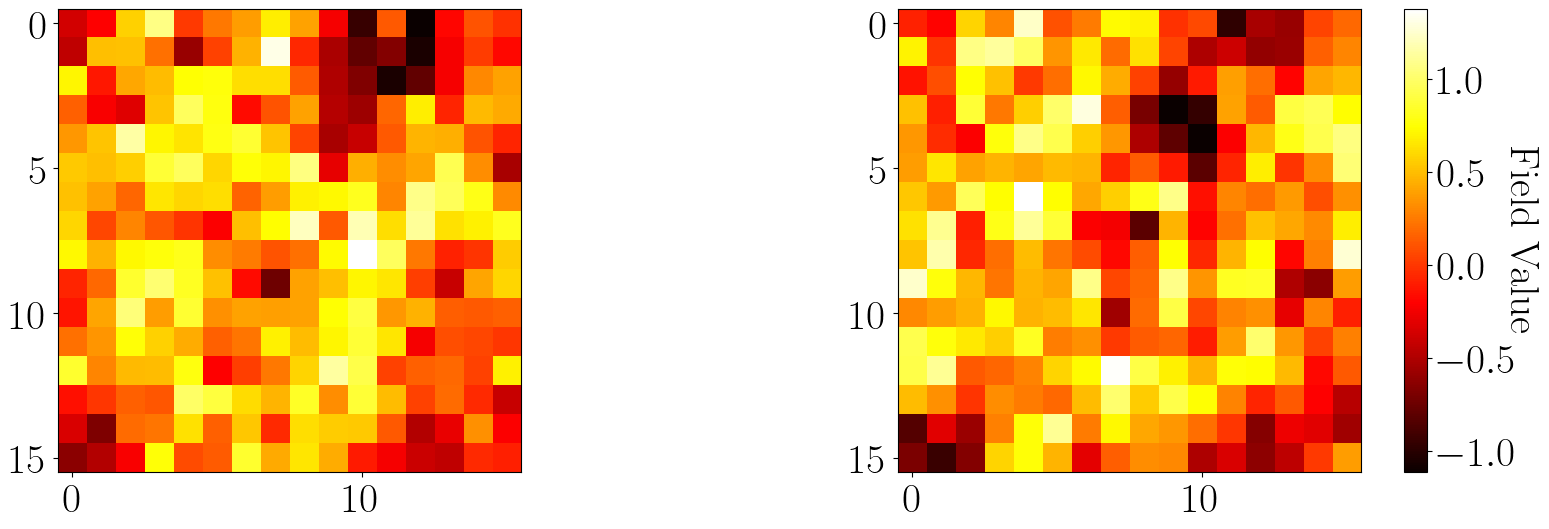

difference coarse level:  tensor(31.6230, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
refining level  torch.Size([10, 16, 16])
reject rate:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
tensor(1.)


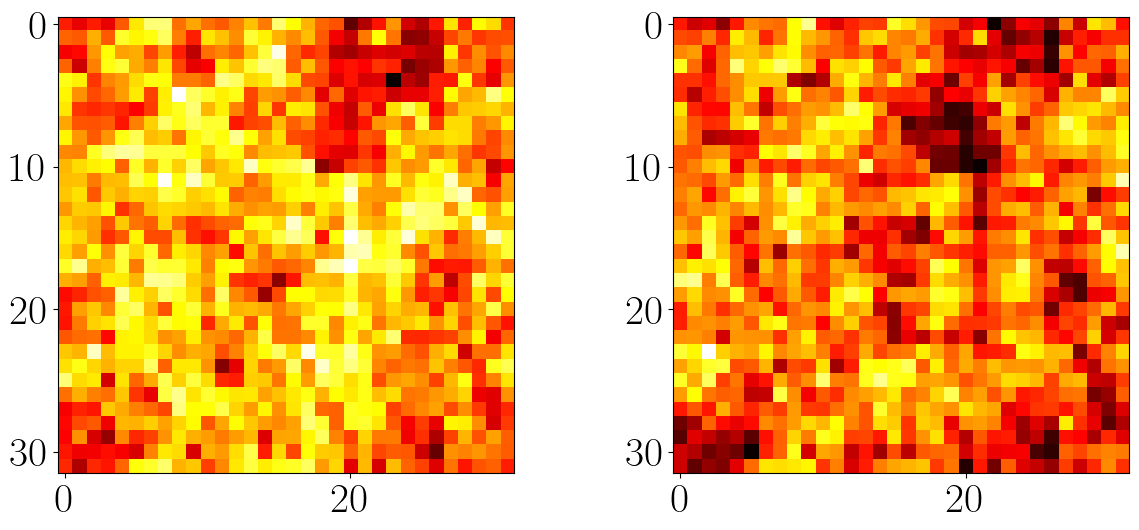

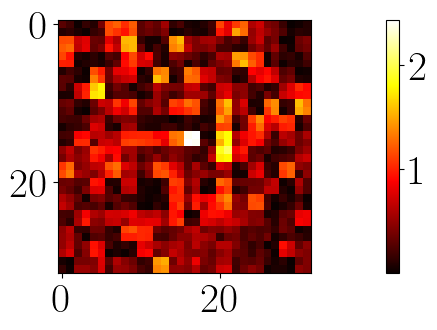

In [61]:
import phi4_mg as phimg
#rg = RGlayer1("average",batch_size=batch_size,dtype=tr.float64,device=device)
import integrators as i

sg2 = phi4_c1(sg,mgf,device=device,dtype=tr.float64,mode="rnvp")
mn2_2 = i.minnorm2(sg2.force,sg2.evolveQ,8,1.0)
hmc_2 = u.hmc(T=sg2,I=mn2_2,verbose=False)
#Nlevels=2
sg2.generate_cfg_levels(phi)
phi2=sg2.phis[-1]
print("shape of action of coarse",sg2.action(phi2))

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi2[0,:,:].detach().cpu(), cmap='hot', interpolation='nearest')
print("phi2 device: ", phi2.device, phi2.dtype, phi2.shape)
phinew = hmc_2.evolve(phi2,1)
#phinew = phi2
ax[1].imshow(phinew[0,:,:].detach().cpu(), cmap='hot', interpolation='nearest')
#colorbar
cbar=plt.colorbar(ax[1].imshow(phinew[0,:,:].detach().cpu(), cmap='hot', interpolation='nearest'), ax=ax[1])
cbar.set_label('Field Value', rotation=270, labelpad=15)
plt.show()
print("difference coarse level: ",tr.norm(phi2-phinew))
for sss in reversed(range(mgf.depth)):
    print("refining level ",phinew.shape)
    phinew= mgf.rg.refine(phinew,sg2.pics[sss])

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi[0,:,:].detach().cpu(), cmap='hot', interpolation='nearest')
#phinew=hmc.evolve(phinew,1)
ax[1].imshow(phinew[0,:,:].detach().cpu(), cmap='hot', interpolation='nearest')
fig.savefig("phi_fine_coarse.svg", bbox_inches='tight',dpi=300)
print("reject rate: ",hmc_2.AcceptReject )
diff=(phi-phinew)
#plot diff
print(tr.tensor(hmc_2.AcceptReject).sum()/len(hmc_2.AcceptReject))
plt.figure(figsize=(16, 4))
plt.imshow(tr.abs(diff[0,:,:]).detach().cpu(), cmap='hot', interpolation='nearest')
plt.colorbar()

### train before running MCMG

In [146]:
#still need to change the code of phi_coarse try Vcycle instead
def V_cycle(phi_o,sgc_c,mgf_c,hmc_f,m1,m2,Nskip=1,mode="normal"):#mode="rnvp"
    phi_o= hmc_f.evolve(phi_o,m1)
    sgc = phi4_c1(sgc_c,mgf_c,device=sgc_c.device,dtype=sgc_c.dtype,mode=mode)
    mn2c = i.minnorm2(sgc.force,sgc.evolveQ,7,1.0)
    hmcc = u.hmc(T=sgc,I=mn2c,verbose=True)
    sgc.generate_cfg_levels(phi_o)
    phic=sgc.phis[-1]
    phic_up=hmcc.evolve(phic,Nskip)
    #now go back up
    for sss in reversed(range(mgf_c.depth)):
        phic_up= mgf_c.rg.refine(phic_up,sgc.pics[sss])

    #print("shape of fine field ",phic_up.shape)
    phic_up=hmc_f.evolve(phic_up,m2)
    return phic_up, hmcc.AcceptReject

#get_observables_MCMG(sg,mgf, hmc, phi, Nwarm, Nmeas, pp=)

def get_observables_MCMG(sg,mgf, hmc, phi, Nwarm, Nmeas,pp="print",mode="normal"):

    tic=time.perf_counter()
    Vol=sg.Vol
    lat=[phi.shape[1], phi.shape[2]]
    toc=time.perf_counter()

    print(f"time {(toc - tic)*1.0e6/Nwarm:0.4f} micro-seconds per HMC trajecrory")

    lC2p = []
    lchi_m = []
    E = []
    av_phi = []
    phase=tr.tensor(np.exp(1j*np.indices(tuple(lat))[0]*2*np.pi/lat[0]),dtype=sg.dtype,device=sg.device)
    for k in range(Nmeas):
        ttE = sg.action(phi)/Vol
        E.extend(ttE)
        av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
        av_phi.extend(av_sigma)
        chi_m = av_sigma*av_sigma*Vol
        p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
        C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
        if(k%10==0) and pp=="print":
            print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().detach().numpy(),chi_m.mean().detach().numpy(),C2p.mean().detach().numpy(),ttE.mean().detach().numpy())
        lC2p.extend(C2p)
        lchi_m.extend(chi_m)
        ## HMC update but also V cycle
        phi,accept=V_cycle(phi,sg,mgf,hmc,1,1,Nskip=Nskip,mode=mode)

    return lC2p, lchi_m, E, av_phi, phi

In [147]:
import integrators as i
import mgmc as mgmc


device = tr.device("cuda")
dtype=tr.float32
L=16
lat = [L,L]
V=L*L
# This set of params is very very close to critical.
lam = 2.4
mas = -0.55

normal = distributions.Normal(tr.zeros(V,dtype=dtype,device=device),tr.ones(V,dtype=dtype,device=device))
prior= distributions.Independent(normal, 1)


Nwarm = 1
Nmeas = 2000
Nskip = 1
batch_size = 10

Vol = np.prod(lat)
sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device,dtype=dtype)
phi = sg.hotStart()
mn2 = i.minnorm2(sg.force,sg.evolveQ,10,1.0)
print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
hmc = u.hmc(T=sg,I=mn2,verbose=False)

FLOW=lambda: m.FlowBijectorParity(Nlayers=1,width=32)

mgf=MGflow1([L,L],FLOW,m.RGlayer("average",batch_size=batch_size,dtype=dtype,device=device),prior,depth=1).to(device)#.double()



torch.Size([10, 16, 16]) 256 tensor(0.0324, device='cuda:0') tensor(0.9991, device='cuda:0')
Initializing MGflow module with size:  16
Using depth:  1
Using rg type:  average
(depth, size):  0 [16, 16]


### No train

In [ ]:

lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,mgf, hmc, phi, Nwarm, Nmeas, pp="no",mode="rnvp")


time 5.4445 micro-seconds per HMC trajecrory
multigrid is done by:  rnvp
 HMC:  0  DH=  [-0.15264892578125, -0.005828857421875, 0.0919189453125, -0.40533447265625, -0.418914794921875, -0.007476806640625, 0.034454345703125, 0.069671630859375, -0.32354736328125, -0.28192138671875]  A/R=  [True, True, True, True, True, True, True, True, True, True]  Pacc=  1.0
multigrid is done by:  rnvp
 HMC:  0  DH=  [-0.2844085693359375, -0.445465087890625, -0.1389007568359375, 0.1089935302734375, 0.0329437255859375, 0.0216064453125, 0.0479888916015625, -0.0241851806640625, 0.4521484375, 0.2361602783203125]  A/R=  [True, True, True, True, True, True, True, True, True, False]  Pacc=  0.9000000357627869
multigrid is done by:  rnvp
 HMC:  0  DH=  [-0.0130767822265625, -0.0474090576171875, 0.072479248046875, 0.09637451171875, 0.1656341552734375, 0.0250091552734375, 0.0656585693359375, 0.2311553955078125, -0.228790283203125, -0.31219482421875]  A/R=  [True, True, True, True, True, True, True, False, True, T

In [12]:
mgf

MGflow1(
  (rg): RGlayer(
    (restrict): Conv2d(1, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (prolong): ConvTranspose2d(1, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
  )
  (cflow): ModuleList(
    (0): ConvFlowLayer(
      (bj): ModuleList(
        (0-1): 2 x RealNVP(
          (t): ModuleList(
            (0-1): 2 x ParityNet(
              (net): Sequential(
                (0): Linear(in_features=4, out_features=32, bias=True)
                (1): LeakyReLU(negative_slope=0.01)
                (2): Linear(in_features=32, out_features=32, bias=True)
                (3): LeakyReLU(negative_slope=0.01)
                (4): Linear(in_features=32, out_features=4, bias=True)
              )
            )
          )
          (s): ModuleList(
            (0-1): 2 x ParityNet(
              (net): Sequential(
                (0): Linear(in_features=4, out_features=32, bias=True)
                (1): LeakyReLU(negative_slope=0.01)
                (2): Linear(in_features=

In [37]:
lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,mgf, hmc, phi, Nwarm, Nmeas, pp="no",mode="rnvp")

time 4.7390 micro-seconds per HMC trajecrory
multigrid is done by:  rnvp
 HMC:  0  DH=  [0.787872314453125, -0.026397705078125, 0.021392822265625, -0.21478271484375, 0.1116943359375, -0.1263427734375, 0.51824951171875, 0.212066650390625, -0.062744140625, -0.24298095703125]  A/R=  [False, True, True, True, True, True, True, True, True, True]  Pacc=  0.9000000357627869
multigrid is done by:  rnvp
 HMC:  0  DH=  [0.26751708984375, 0.2469482421875, 0.1614990234375, 0.051605224609375, -0.1016845703125, 0.055328369140625, 0.006103515625, -0.1204681396484375, 0.008880615234375, 0.073150634765625]  A/R=  [True, False, True, True, True, True, True, True, True, True]  Pacc=  0.9000000357627869
multigrid is done by:  rnvp
 HMC:  0  DH=  [-0.057861328125, 0.250579833984375, 0.113067626953125, -0.133148193359375, 0.01043701171875, 0.0589752197265625, 0.1185455322265625, 0.071685791015625, 0.248016357421875, 0.05029296875]  A/R=  [True, True, True, True, True, True, True, True, True, True]  Pacc=  1

In [ ]:
Nmeas/batch_size

10.0

/local/scr/yacahuanamedra/TMPDIR/ipykernel_2441772/1559955516.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


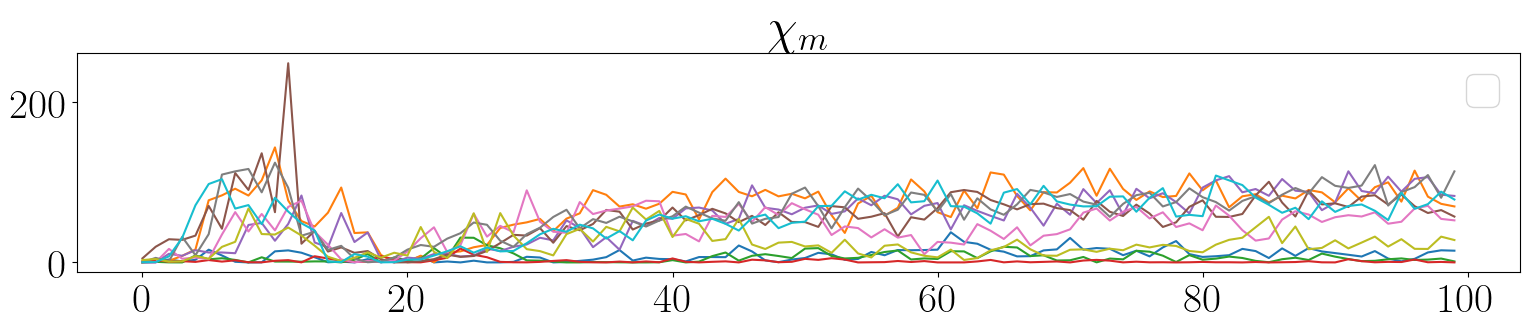

/local/scr/yacahuanamedra/TMPDIR/ipykernel_2441772/1559955516.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


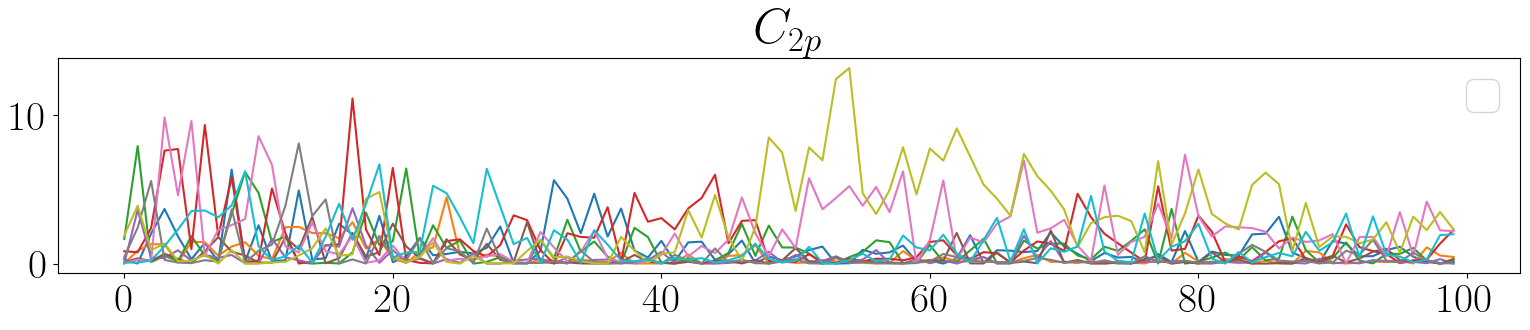

/local/scr/yacahuanamedra/TMPDIR/ipykernel_2441772/1559955516.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


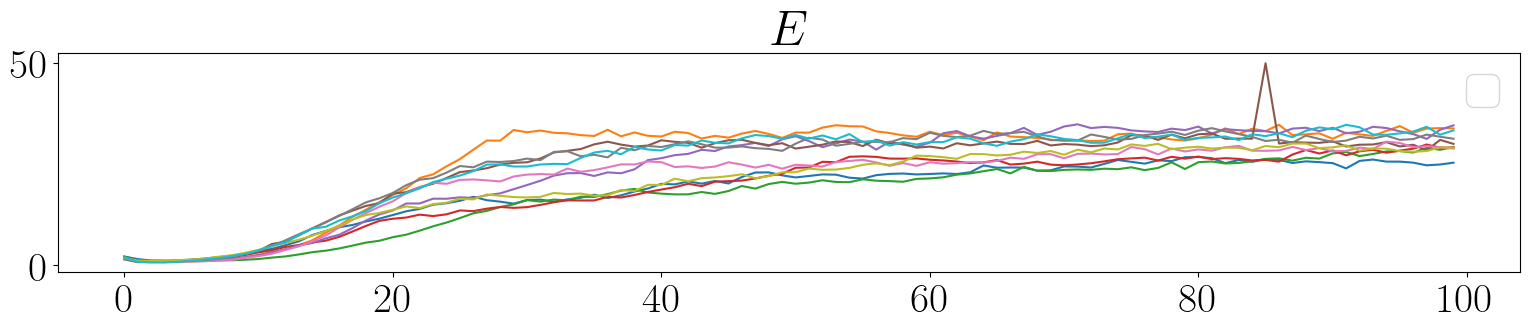

/local/scr/yacahuanamedra/TMPDIR/ipykernel_2441772/1559955516.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


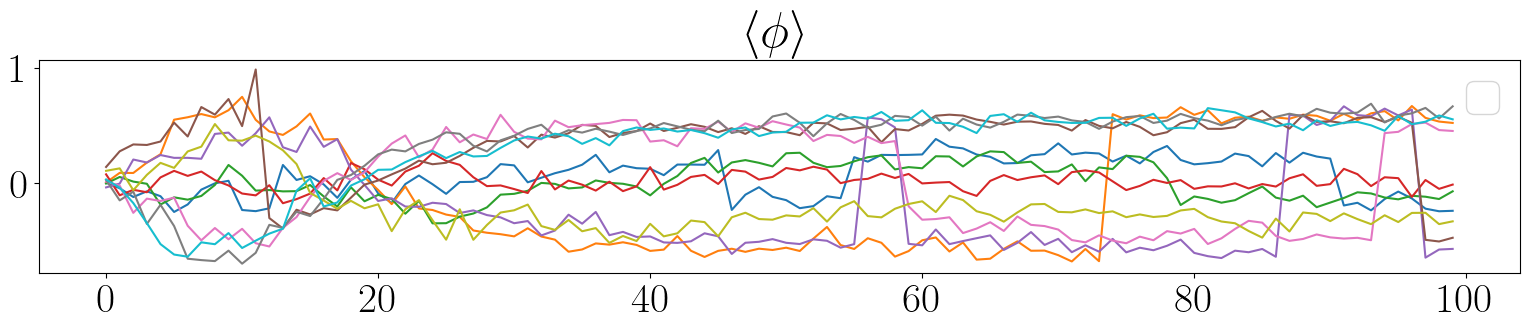

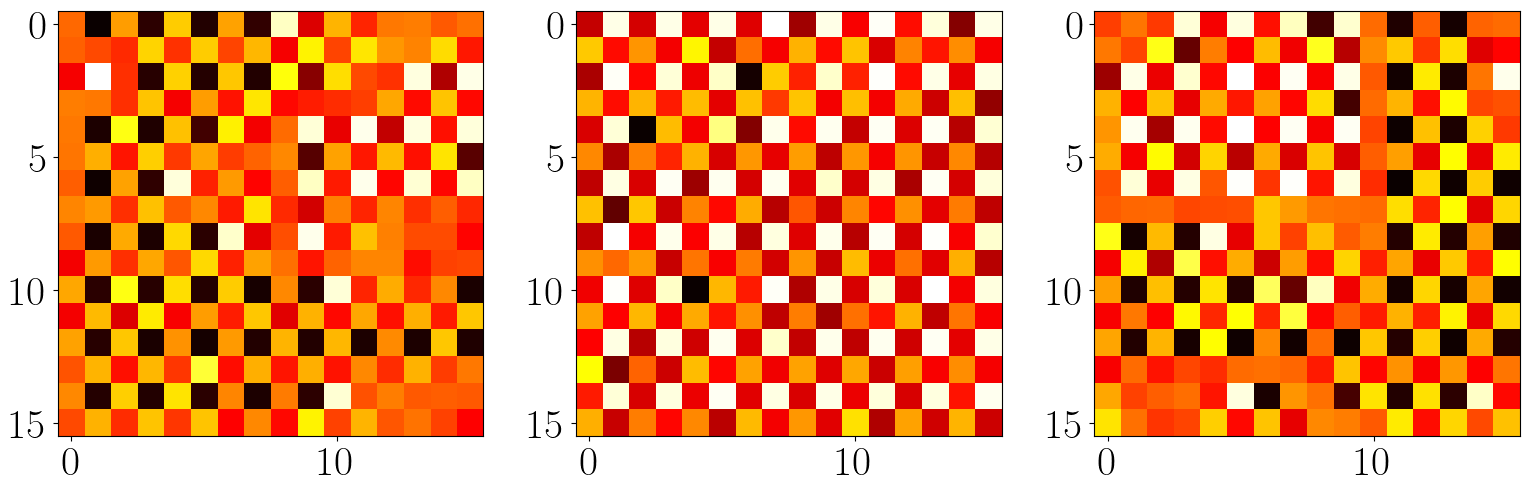

In [54]:

#size of the plot
plt.figure(figsize=(16, 4))
plt.title(r"$\chi_m$")
plt.plot(range(Nmeas),tr.tensor(lchi_m).reshape(100,10).to("cpu"))#, label=r'$\chi_m$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$C_{2p}$")
plt.plot(range(Nmeas),tr.tensor(lC2p).reshape(100,10).to("cpu"))#, label=r'$C_{2p}$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$E$")
plt.plot(range(Nmeas),tr.tensor(E).reshape(100,10).to("cpu"))#, label=r'$E$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$\langle \phi \rangle$")
plt.plot(range(Nmeas),tr.tensor(av_phi).reshape(100,10).to("cpu"))#, label=r'$\langle\phi\rangle$')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(16, 8))
for i in range(0,3):
    ax[i].imshow(phi[i,:,:].to("cpu").detach().numpy(), cmap='hot', interpolation='nearest')


/local/scr/yacahuanamedra/TMPDIR/ipykernel_2479275/1559955516.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


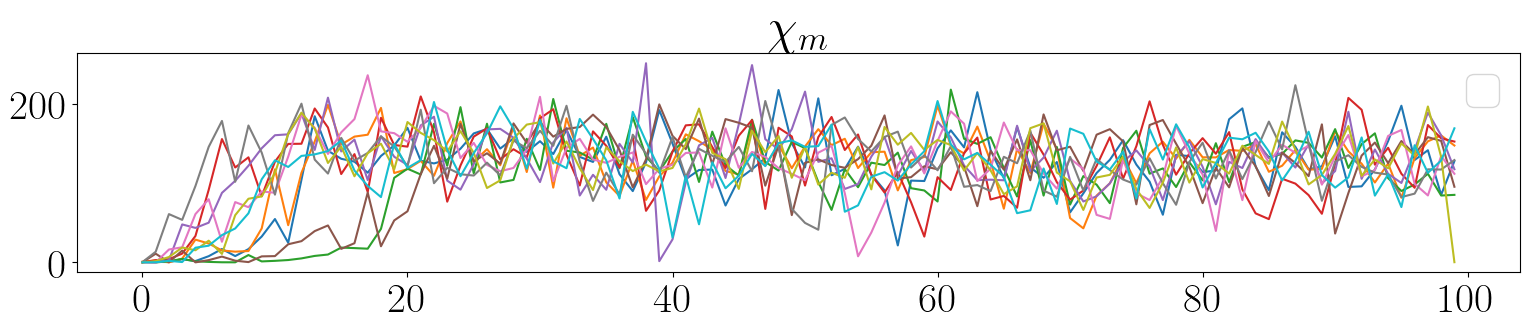

/local/scr/yacahuanamedra/TMPDIR/ipykernel_2479275/1559955516.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


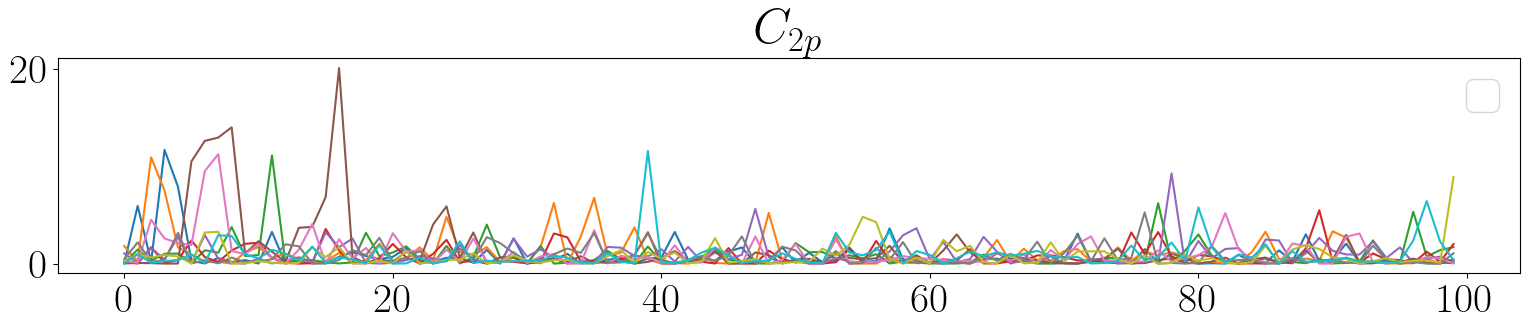

/local/scr/yacahuanamedra/TMPDIR/ipykernel_2479275/1559955516.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


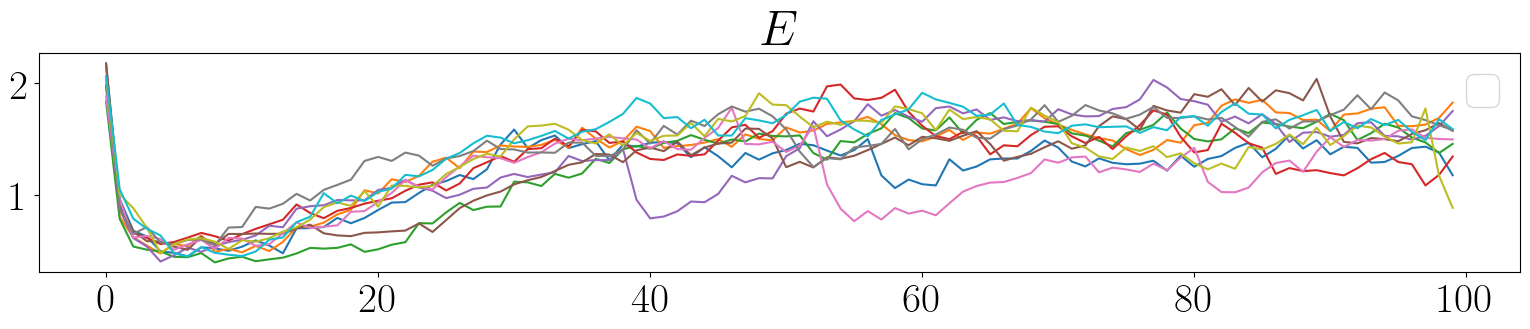

/local/scr/yacahuanamedra/TMPDIR/ipykernel_2479275/1559955516.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


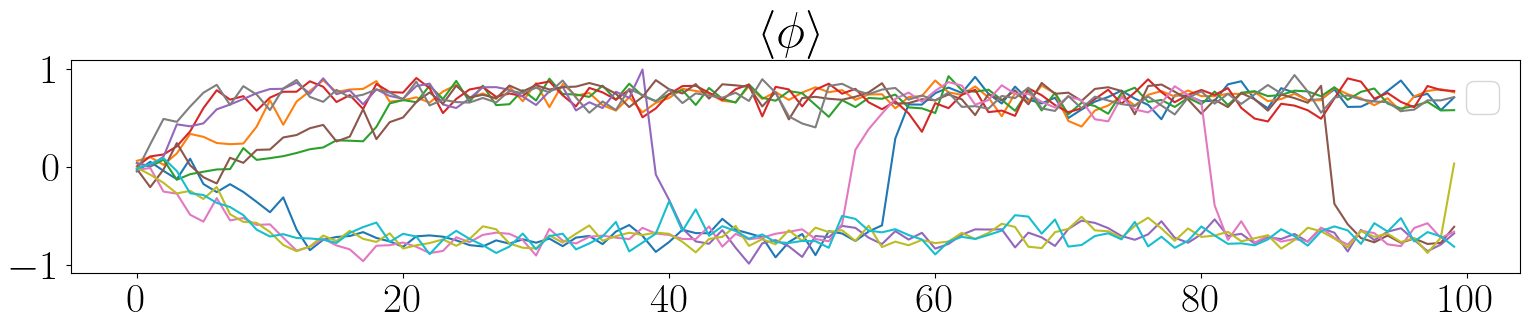

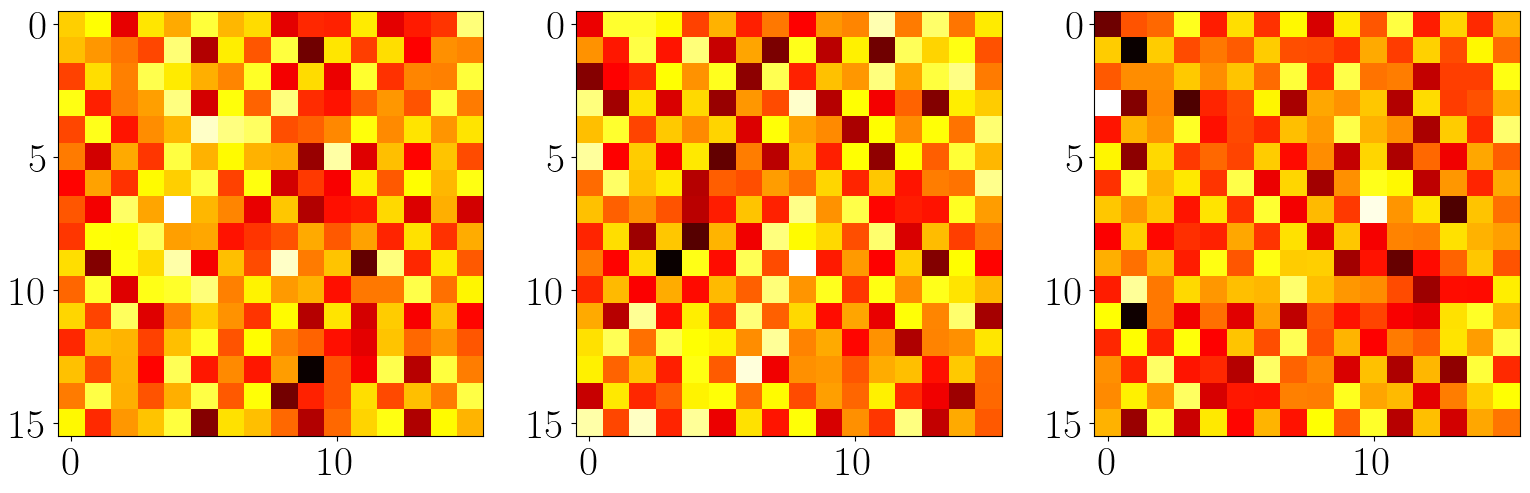

In [26]:

#size of the plot
plt.figure(figsize=(16, 4))
plt.title(r"$\chi_m$")
plt.plot(range(Nmeas),tr.tensor(lchi_m).reshape(100,10).to("cpu"))#, label=r'$\chi_m$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$C_{2p}$")
plt.plot(range(Nmeas),tr.tensor(lC2p).reshape(100,10).to("cpu"))#, label=r'$C_{2p}$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$E$")
plt.plot(range(Nmeas),tr.tensor(E).reshape(100,10).to("cpu"))#, label=r'$E$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$\langle \phi \rangle$")
plt.plot(range(Nmeas),tr.tensor(av_phi).reshape(100,10).to("cpu"))#, label=r'$\langle\phi\rangle$')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(16, 8))
for i in range(0,3):
    ax[i].imshow(phi[i,:,:].to("cpu").detach().numpy(), cmap='hot', interpolation='nearest')


### Train

In [148]:
c=0
for tt in mgf.parameters():
    #print(tt.shape)
    c+=tt.numel()

print("parameter count: ",c)

optimizer = tr.optim.Adam([p for p in mgf.parameters() if p.requires_grad==True], lr=1e-4)


parameter count:  10808


In [149]:
loss_history = []
super_batch_size = 10
for t in range(1001):   
    #with torch.no_grad():
    #z = prior.sample((batch_size,1)).squeeze().reshape(batch_size,L,L)
    z = mgf.prior_sample(batch_size)
    #print(z.shape,z.device)
    x = mgf(z) # generate a sample
    #print(x.shape,x.device)
    tloss = (mgf.log_prob(x)+sg.action(x))
    for b in range(1,super_batch_size):
        z = mgf.prior_sample(batch_size)
        x = mgf(z) # generate a sample
        tloss += (mgf.log_prob(x)+sg.action(x)) # KL divergence (or not?)
    loss =tloss.mean()/super_batch_size

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    loss_history.append(loss.cpu().detach().numpy())
    #print(loss_history[-1])
    if t % 50 == 0:
        #print(z.shape)
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 89.541
iter 50: loss = 12.349
iter 100: loss = -28.431
iter 150: loss = -56.665
iter 200: loss = -73.625
iter 250: loss = -84.693
iter 300: loss = -88.561
iter 350: loss = -90.491
iter 400: loss = -91.875
iter 450: loss = -91.951
iter 500: loss = -93.102
iter 550: loss = -93.391
iter 600: loss = -93.331
iter 650: loss = -93.725
iter 700: loss = -93.757
iter 750: loss = -94.179
iter 800: loss = -94.393
iter 850: loss = -93.919
iter 900: loss = -94.392
iter 950: loss = -95.036
iter 1000: loss = -94.347


In [150]:
#deactivate mgf parameters
for p in mgf.parameters():
    p.requires_grad = False
    #and also graph
    p.graph = False

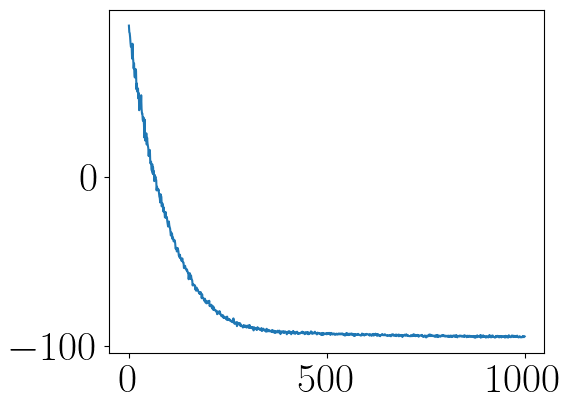

In [151]:
#plot loss
plt.plot(loss_history)
plt.show()


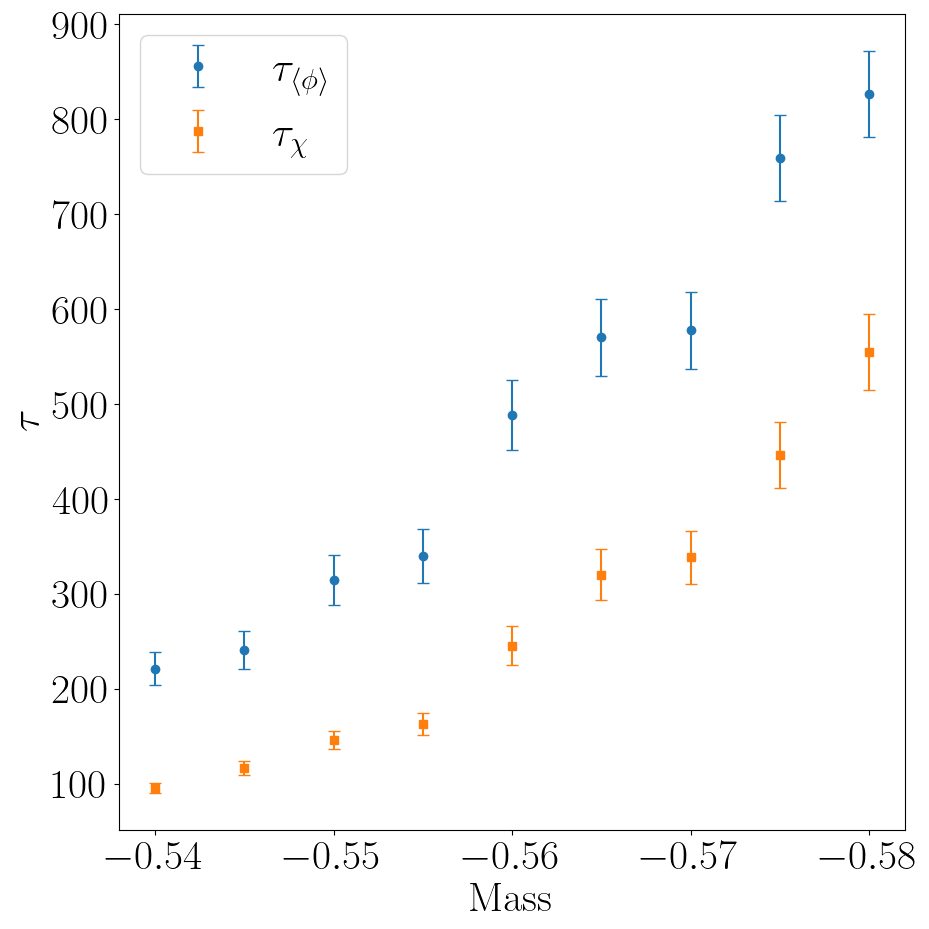

In [47]:
data = np.loadtxt("MCMG_results_L128_lam2.4.txt", comments="#")

mass = data[:, 0]

tau_phi1 = data[:, 7]
dtau_phi1 = data[:, 8]

tau_suscept1 = data[:, 11]
dtau_suscept1 = data[:, 12]

# Ordenar por masa (importante)
idx = np.argsort(mass)
mass = mass[idx]
tau_phi1 = tau_phi1[idx]
dtau_phi1 = dtau_phi1[idx]
tau_suscept1 = tau_suscept1[idx]
dtau_suscept1 = dtau_suscept1[idx]

plt.figure(figsize=(10,10))

plt.errorbar(
    mass, tau_phi1, yerr=dtau_phi1,
    fmt='o', capsize=4, label=r"$\tau_{\langle\phi\rangle}$"
)

plt.errorbar(
    mass, tau_suscept1, yerr=dtau_suscept1,
    fmt='s', capsize=4, label=r"$\tau_{\chi}$"
)

plt.xlabel("Mass")
plt.ylabel(r"$\tau$")
#reverse x axis
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()

In [152]:
import integrators as i
lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,mgf, hmc, phi, Nwarm, Nmeas, pp="no",mode="rnvp")

time 5.0403 micro-seconds per HMC trajecrory
multigrid is done by:  rnvp


 HMC:  0  DH=  [-0.00286865234375, 0.023590087890625, 0.025238037109375, -0.047332763671875, 0.0196533203125, -0.0521087646484375, 0.0368499755859375, -0.1466522216796875, 0.0248870849609375, 0.037109375]  A/R=  [True, True, True, True, True, True, True, True, True, True]  Pacc=  1.0
multigrid is done by:  rnvp
 HMC:  0  DH=  [-0.0312347412109375, 0.0048370361328125, 0.025909423828125, -0.0112457275390625, -0.04510498046875, -0.0329742431640625, -0.005645751953125, -0.0063629150390625, 0.0574493408203125, 0.02410888671875]  A/R=  [True, True, True, True, True, True, True, True, True, True]  Pacc=  1.0
multigrid is done by:  rnvp
 HMC:  0  DH=  [0.02410888671875, -0.019287109375, 0.0812225341796875, 0.043731689453125, 0.03369140625, 0.02166748046875, -0.032379150390625, 0.0236968994140625, 0.044708251953125, 0.0437469482421875]  A/R=  [True, True, True, True, True, True, True, True, True, True]  Pacc=  1.0
multigrid is done by:  rnvp
 HMC:  0  DH=  [-0.0576171875, -0.060699462890625, -0

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1854992/3185645638.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


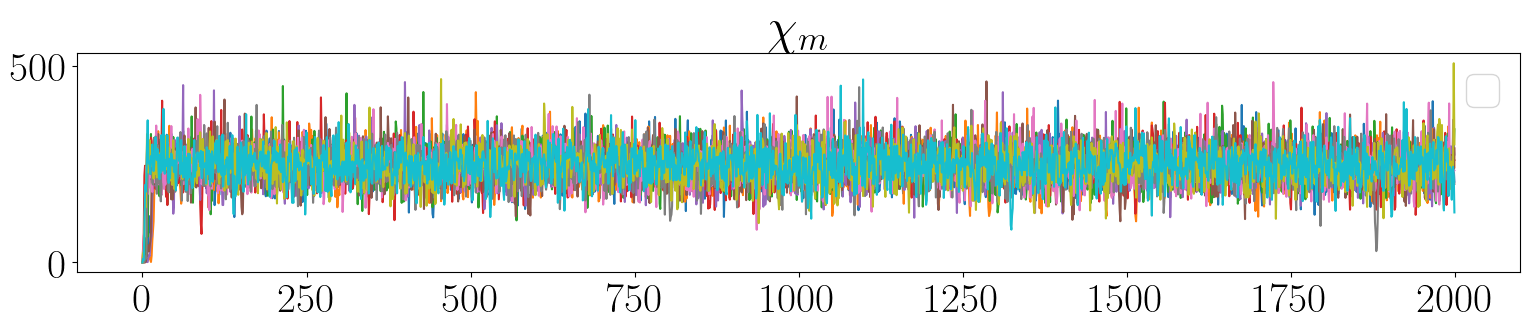

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1854992/3185645638.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


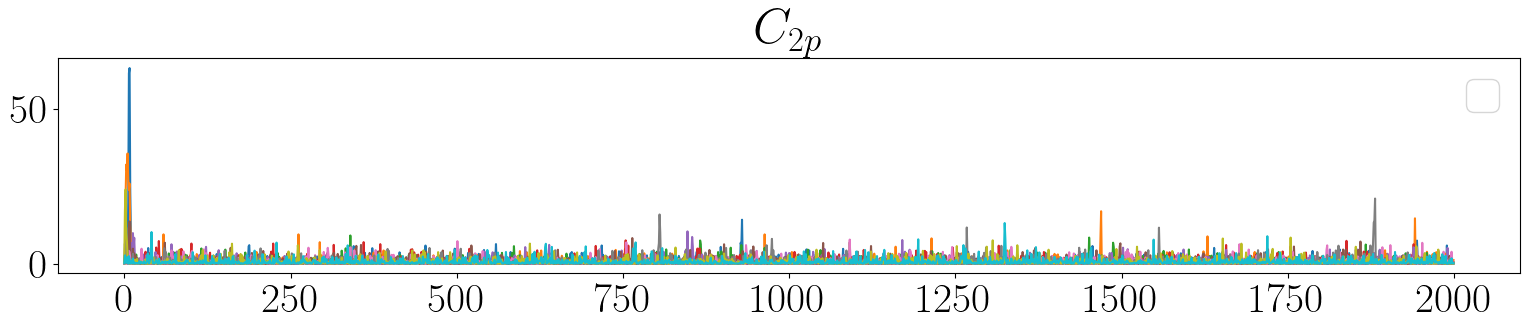

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1854992/3185645638.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


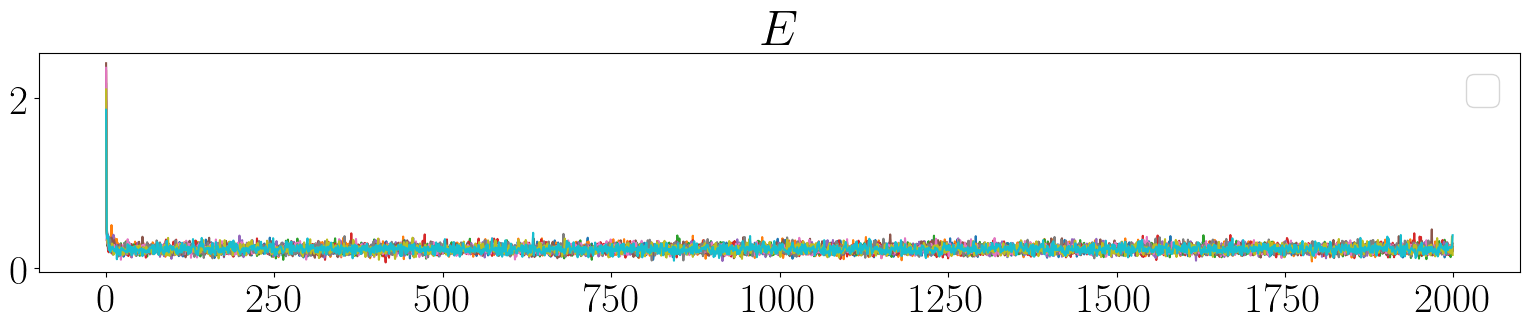

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1854992/3185645638.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


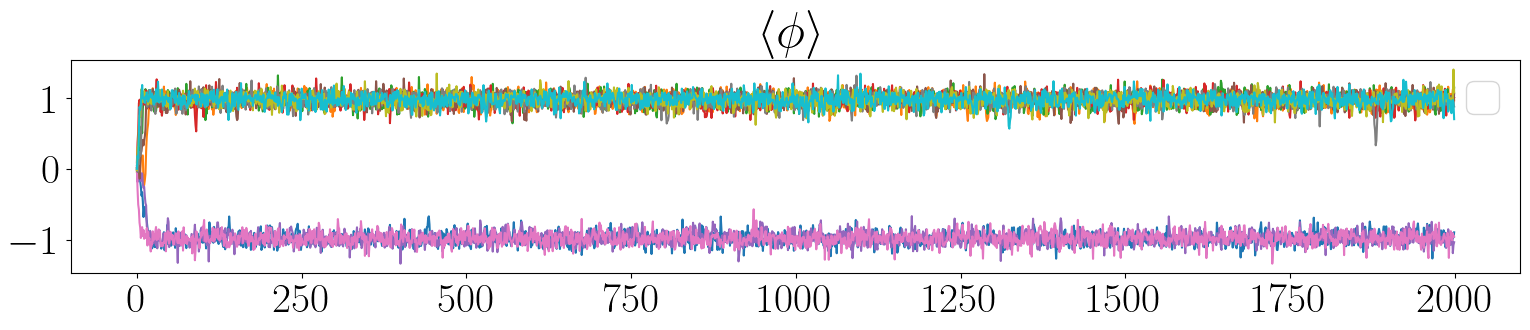

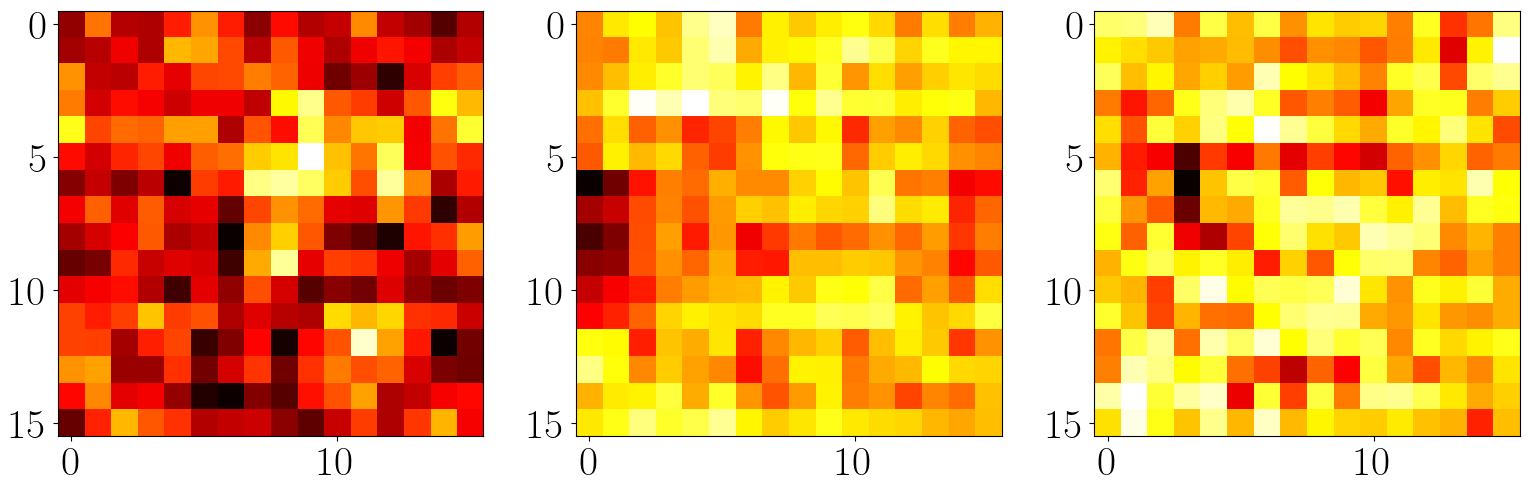

In [143]:
#size of the plot
Nmeas = 2000
Nmeas1 = 2000
plt.figure(figsize=(16, 4))
plt.title(r"$\chi_m$")
plt.plot(range(Nmeas),tr.tensor(lchi_m).reshape(Nmeas1,10).to("cpu")[:Nmeas])#, label=r'$\chi_m$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$C_{2p}$")
plt.plot(range(Nmeas),tr.tensor(lC2p).reshape(Nmeas1,10).to("cpu")[:Nmeas])#, label=r'$C_{2p}$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$E$")
plt.plot(range(Nmeas),tr.tensor(E).reshape(Nmeas1,10).to("cpu")[:Nmeas])#, label=r'$E$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$\langle \phi \rangle$")
plt.plot(range(Nmeas),tr.tensor(av_phi).reshape(Nmeas1,10).to("cpu")[:Nmeas])#, label=r'$\langle\phi\rangle$')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(16, 8))
for i in range(0,3):
    ax[i].imshow(phi[i,:,:].to("cpu").detach().numpy(), cmap='hot', interpolation='nearest')


/local/scr/yacahuanamedra/TMPDIR/ipykernel_1854992/3185645638.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


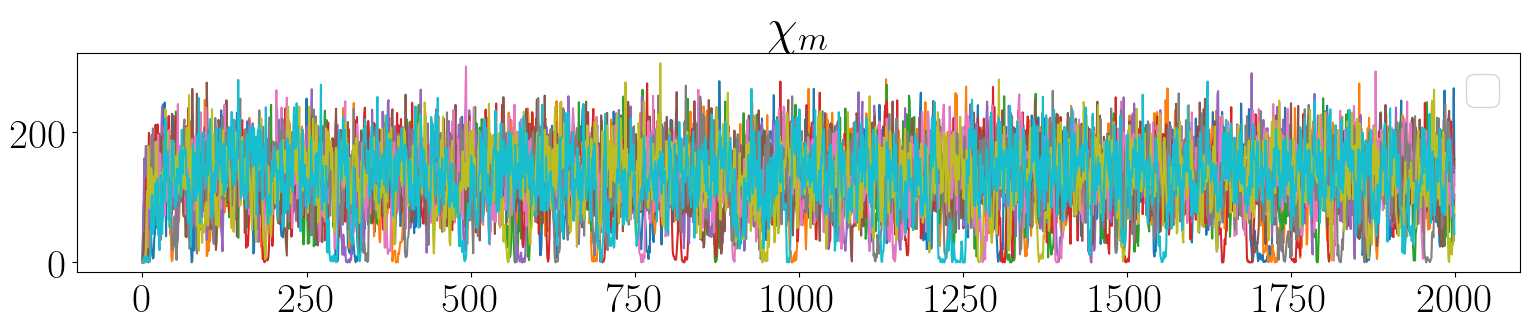

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1854992/3185645638.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


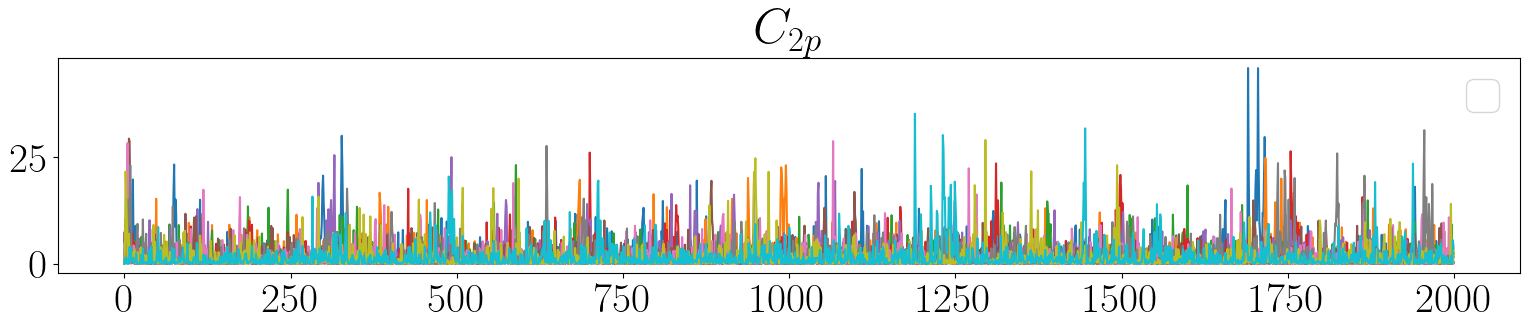

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1854992/3185645638.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


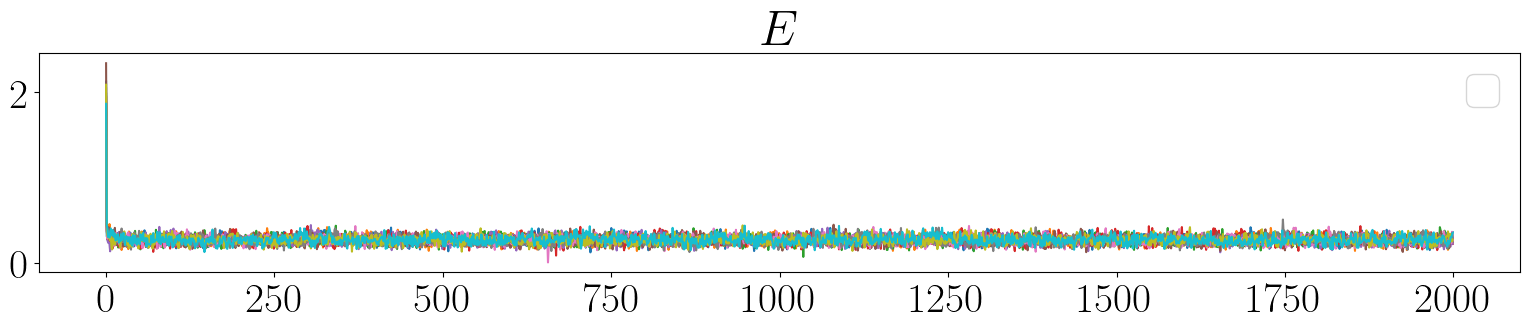

/local/scr/yacahuanamedra/TMPDIR/ipykernel_1854992/3185645638.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


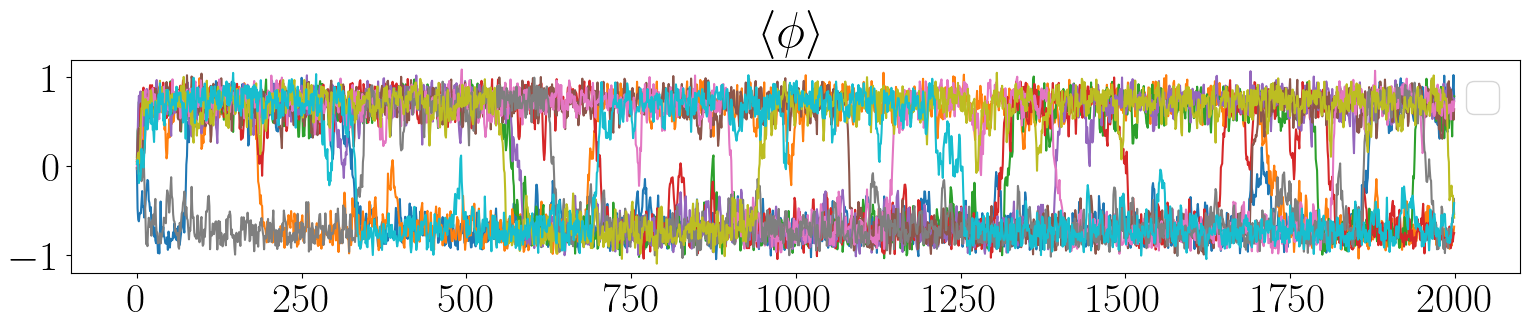

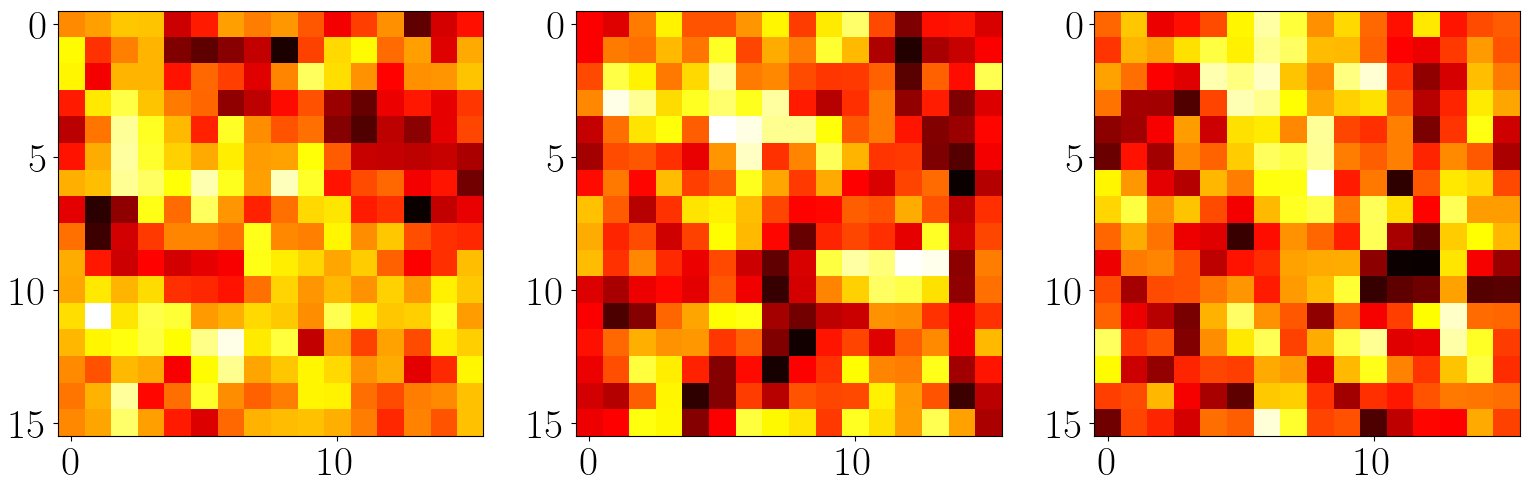

In [153]:
#size of the plot
Nmeas = 2000
Nmeas1 = 2000
plt.figure(figsize=(16, 4))
plt.title(r"$\chi_m$")
plt.plot(range(Nmeas),tr.tensor(lchi_m).reshape(Nmeas1,10).to("cpu")[:Nmeas])#, label=r'$\chi_m$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$C_{2p}$")
plt.plot(range(Nmeas),tr.tensor(lC2p).reshape(Nmeas1,10).to("cpu")[:Nmeas])#, label=r'$C_{2p}$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$E$")
plt.plot(range(Nmeas),tr.tensor(E).reshape(Nmeas1,10).to("cpu")[:Nmeas])#, label=r'$E$')
plt.legend()
plt.show()
plt.figure(figsize=(16, 4))
plt.title(r"$\langle \phi \rangle$")
plt.plot(range(Nmeas),tr.tensor(av_phi).reshape(Nmeas1,10).to("cpu")[:Nmeas])#, label=r'$\langle\phi\rangle$')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,3, figsize=(16, 8))
for i in range(0,3):
    ax[i].imshow(phi[i,:,:].to("cpu").detach().numpy(), cmap='hot', interpolation='nearest')


In [ ]:

print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
hmc = u.hmc(T=sg,I=mn2,verbose=False)
mgf=MGflow1([L,L],m.FlowBijectorParity,m.RGlayer("average",batch_size=batch_size,dtype=dtype,device=device),prior,depth=1).to(device)#.double()
#rg = phimg.RGlayer("average",batch_size=batch_size)

lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,mgf, hmc, phi, Nwarm, Nmeas, pp="no",mode="rnvp")

torch.Size([20, 8, 8]) 64 tensor(0.0147, device='cuda:0') tensor(1.0175, device='cuda:0')
Initializing MGflow module with size:  8
Using depth:  1
Using rg type:  average
(depth, size):  0 [8, 8]
time 11.4278 micro-seconds per HMC trajecrory
multigrid is done by:  rnvp
 HMC:  0  DH=  [0.39202880859375, -0.06475830078125, -0.235443115234375, 0.32959747314453125, -0.0504302978515625, 0.1229248046875, -0.062774658203125, -0.11444091796875, 0.0735015869140625, -0.063751220703125, 0.135467529296875, -0.42295074462890625, 0.154022216796875, -0.09014511108398438, 0.019378662109375, 0.11510467529296875, 0.1279144287109375, -0.21819305419921875, -0.12818145751953125, 0.2344512939453125]  A/R=  [True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False]  Pacc=  0.9000000357627869
multigrid is done by:  rnvp
 HMC:  0  DH=  [0.40606689453125, 0.033245086669921875, -0.154022216796875, 0.08889007568359375, -0.013111114501953125, 0.219200

In [29]:
import torch
import gc

total = 0
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj):
            size_MB = obj.element_size() * obj.nelement() / 1024**2
            total += size_MB
            print(f"{type(obj):<30} | {obj.size()} | {size_MB:.2f} MB")
    except:
        pass

print(f"\nTotal GPU memory used by tracked tensors: {total:.2f} MB")

/sciclone/home/yacahuanamedra/.conda/envs/torchQFT-env/lib/python3.12/site-packages/torch/__init__.py:836: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)



Total GPU memory used by tracked tensors: 102.91 MB


In [16]:
#memory usage of phi in MB
phi.element_size() * phi.nelement() / 1024**2

0.0048828125

In [27]:
tr.cuda.empty_cache()

In [118]:
free_memory, total_memory = tr.cuda.mem_get_info()
print(f"Total GPU memory: {total_memory / (1024**3):.2f} GB")
print(f"Free GPU memory: {free_memory / (1024**3):.2f} GB")
print(tr.cuda.memory_summary(device=None, abbreviated=False))


Total GPU memory: 23.50 GB
Free GPU memory: 9.69 GB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 270003 KiB |  13717 MiB |  92598 GiB |  92597 GiB |
|       from large pool |  16640 KiB |  12816 MiB |    425 GiB |    425 GiB |
|       from small pool | 253363 KiB |    901 MiB |  92173 GiB |  92172 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 270003 KiB |  13717 MiB |  92598 GiB |  92597 GiB |
|       from

In [29]:
!nvidia-smi

Thu Nov 13 20:22:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           On  |   00000000:04:00.0 Off |                    0 |
| N/A   29C    P0             30W /  250W |    7175MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [63]:
mass_grid2=np.linspace(-.585,-0.54,2)
tau_phi2=np.zeros_like(mass_grid2)
tau_suscept2=np.zeros_like(mass_grid2)
sss=0
for mas in mass_grid2:
    L=64
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 500
    Nmeas = 2000
    Nskip = 1
    batch_size = 1

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)
    rg = phimg.RGlayer("average",batch_size=batch_size)
    

    lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,rg, hmc, phi, Nwarm, Nmeas, Lev=1)
    tau_phi2[sss],tau_suscept2[sss] = get_autocorrelationtime(av_phi, lchi_m)
    sss+=1
    m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([1, 64, 64]) 4096 tensor(-0.0087, device='cuda:0') tensor(0.9844, device='cuda:0')
time 0.0052 micro-seconds per HMC trajecrory


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
mass_grid3=np.linspace(-.585,-0.54,6)
tau_phi3=np.zeros_like(mass_grid3)
tau_suscept3=np.zeros_like(mass_grid3)
sss=0
for mas in mass_grid3:
    L=64
    lat = [L,L]
    # This set of params is very very close to critical.
    lam = 2.4
    #
    Nwarm = 10
    Nmeas = 2000
    Nskip = 1
    batch_size = 1

    Vol = np.prod(lat)
    sg = s.phi4(lat,lam,mas,batch_size=batch_size,device=device)
    phi = sg.hotStart()
    mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
    print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
    hmc = u.hmc(T=sg,I=mn2,verbose=False)
    rg = NonLinearRGlayer(channels=1, hidden_channels=1, batch_size=batch_size)
    

    lC2p, lchi_m, E, av_phi, phi = get_observables_MCMG(sg,rg, hmc, phi, Nwarm, Nmeas, Lev=1)
    tau_phi3[sss],tau_suscept3[sss] = get_autocorrelationtime(av_phi, lchi_m)
    sss+=1
    #m_phi, e_phi,m_chi_m, e_chi_m,m_C2p, e_C2p,avE,eE,xi,m_xi,e_xi,phi=get_observables(lC2p, lchi_m, E, av_phi, phi)

torch.Size([1, 64, 64]) 4096 tensor(-0.0151) tensor(0.9927)
time 0.1403 micro-seconds per HMC trajecrory
k=  0 (av_phi,chi_m, c2p, E)  -0.015104491 0.9344846 0.09005918706005746 1.9716909


k=  10 (av_phi,chi_m, c2p, E)  -0.37677017 581.4508 16.373593413122094 0.40607983
k=  20 (av_phi,chi_m, c2p, E)  -0.509234 1062.1718 18.38932896016239 0.39865112
k=  30 (av_phi,chi_m, c2p, E)  -0.6199784 1574.3928 9.16200502544789 0.37060016
k=  40 (av_phi,chi_m, c2p, E)  -0.67207795 1850.1172 7.531855072658757 0.34692156
k=  50 (av_phi,chi_m, c2p, E)  -0.7205291 2126.4883 6.763256786391959 0.36446297
k=  60 (av_phi,chi_m, c2p, E)  -0.74507403 2273.8342 2.5607110574959373 0.3536834
k=  70 (av_phi,chi_m, c2p, E)  -0.859984 3029.2888 3.814437206222709 0.34161174
k=  80 (av_phi,chi_m, c2p, E)  -0.7739779 2453.675 0.5661553252756875 0.37053555
k=  90 (av_phi,chi_m, c2p, E)  -0.76859945 2419.692 1.883323628224898 0.31652868
k=  100 (av_phi,chi_m, c2p, E)  -0.7925014 2572.5273 4.0118689390430555 0.3192715
k=  110 (av_phi,chi_m, c2p, E)  -0.79144424 2565.6687 0.49470373007104335 0.32894552
k=  120 (av_phi,chi_m, c2p, E)  -0.7519648 2316.0876 2.631338128157484 0.33890897
k=  130 (av_phi,chi_m,

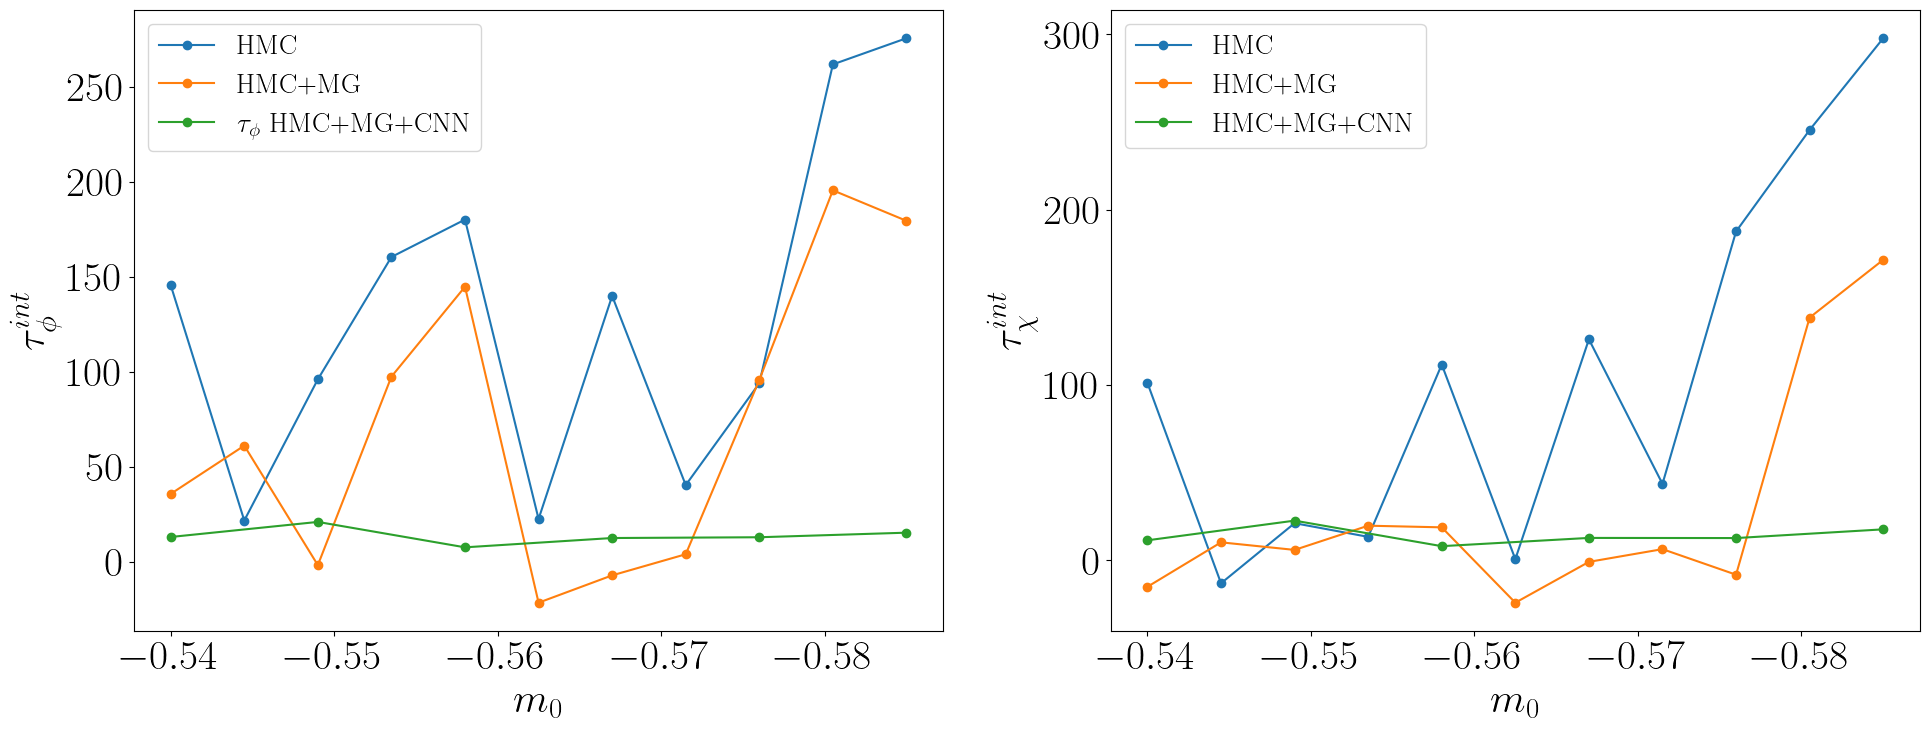

In [25]:
fig, ax = plt.subplots(1,2, figsize=(20, 8))
#reverse mass axis ax
ax[0].invert_xaxis()
ax[0].plot(mass_grid1,tau_phi1,'o-',label=r'HMC')
ax[0].plot(mass_grid2,tau_phi2,'o-',label=r'HMC+MG')
ax[0].plot(mass_grid3,tau_phi3,'o-',label=r'$\tau_{\phi}$ HMC+MG+CNN')
ax[0].set_xlabel(r'$m_0$', fontsize=30)
ax[0].set_ylabel(r'$\tau_{\phi}^{int}$', fontsize=30)
ax[0].legend(fontsize=20)
ax[1].invert_xaxis()
ax[1].plot(mass_grid1,tau_suscept1,'o-',label=r'HMC')
ax[1].plot(mass_grid2,tau_suscept2,'o-',label=r'HMC+MG')
ax[1].plot(mass_grid3,tau_suscept3,'o-',label=r'HMC+MG+CNN')
ax[1].set_xlabel(r'$m_0$', fontsize=30)
ax[1].set_ylabel(r'$\tau_{\chi}^{int}$', fontsize=30)
ax[1].legend(fontsize=20)
#plt.savefig("tau_comparison.svg", bbox_inches='tight',dpi=300)
plt.show()

shape of the original field torch.Size([1, 64, 64])
coarsening level  0  field shape  torch.Size([1, 64, 64])
shape of fine field  torch.Size([1, 64, 64])
shape of new field  torch.Size([1, 64, 64])
reject rate:  [1.0]
tensor(1.)


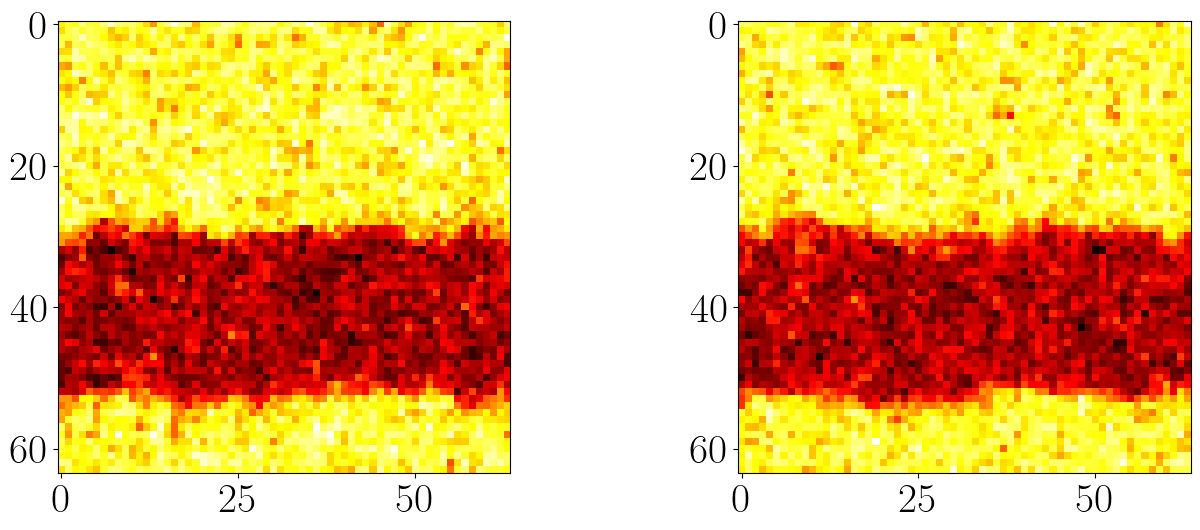

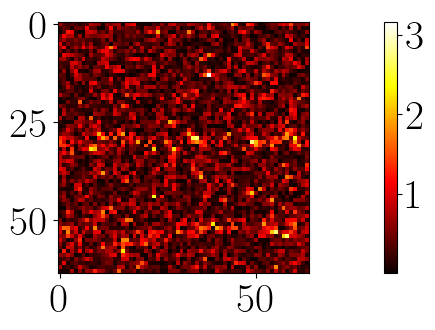

In [ ]:

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
phi_new,accept=V_cycle(phi,sg,rg,hmc,1,1,Nlevels=1)
print("shape of new field ",phi_new.shape)
ax[1].imshow(phi_new[0,:,:], cmap='hot', interpolation='nearest')
print("reject rate: ",accept )
diff=(phi-phi_new)
#plot diff
print(tr.tensor(accept).sum()/len(accept))
plt.figure(figsize=(16, 4))
plt.imshow(tr.abs(diff[0,:,:]).detach(), cmap='hot', interpolation='nearest')
plt.colorbar()


In [ ]:
#still need to change the code of phi_coarse try Vcycle instead
def Wcycle(phi,sg,rg,hmc_f,m1,m2,Nlevels=2,Nskip=1):

    sgc = phi4_c1(sg,rg)
    mn2c = i.minnorm2(sgc.force,sgc.evolveQ,7,1.0)
    hmcc = u.hmc(T=sgc,I=mn2c,verbose=False)
    sgc.generate_cfg_levels(phi,Nlevels)
    phic=sgc.phis[-1]
    phic_up=hmcc.evolve(phic,Nskip)
    #now go back up
    for sss in reversed(range(Nlevels-1)):
        phic_up= rg.refine(phic_up,sgc.pics[sss])
    
    phic_up=hmc_f.evolve(phic_up,m1)
    return phic_up, hmcc.AcceptReject

256

In [56]:
phi_c = sg2.phis[-1]
phi_c.requires_grad_()
S = sg2.action(phi_c)
print("action", S)
grad = tr.autograd.grad(S.sum(), phi_c, retain_graph=True)[0]
print("grad ok? nan:", tr.isnan(grad).any(), "shape:", grad.shape)

action tensor([6299.9238], grad_fn=<SubBackward0>)
grad ok? nan: tensor(False) shape: torch.Size([1, 64, 64])


shape of the original field torch.Size([1, 64, 64])
coarsening level  0  field shape  torch.Size([1, 64, 64])
coarsening level  1  field shape  torch.Size([1, 32, 32])
coarsening level  2  field shape  torch.Size([1, 16, 16])
torch.Size([1, 8, 8])
reject rate:  [1.0]
tensor(1.)


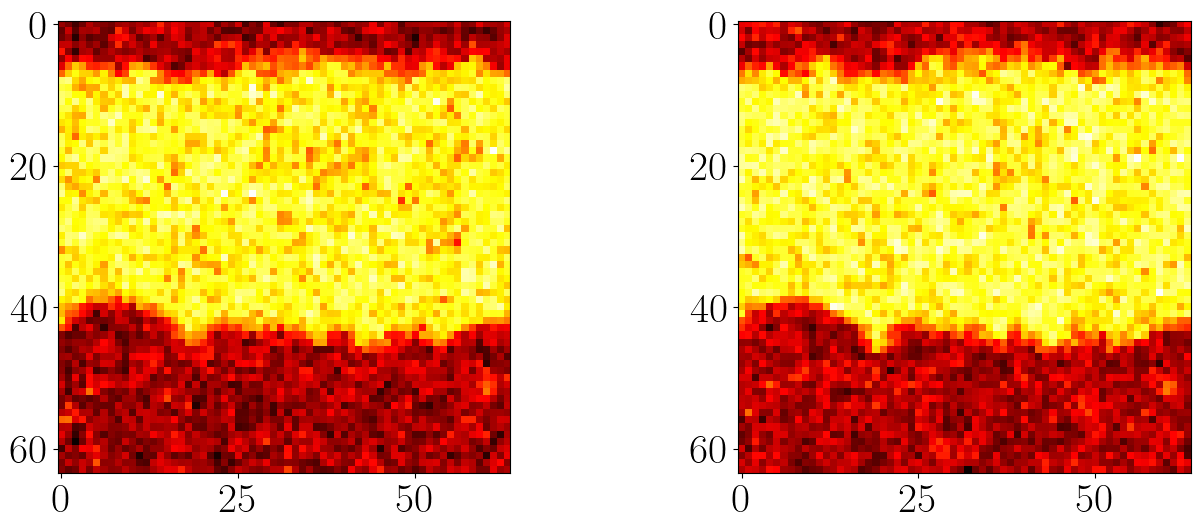

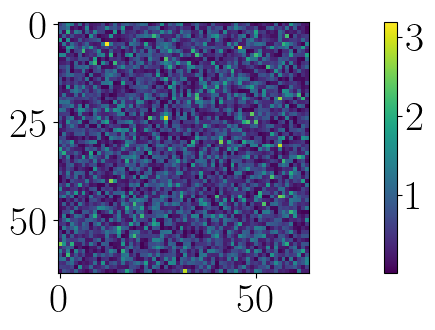

In [ ]:
import phi4_mg as phimg
#rg = NonLinearRGlayer("average",batch_size=batch_size)

rg = NonLinearRGlayer(channels=1, hidden_channels=1, batch_size=batch_size)
import integrators as i

sg2 = phi4_c1(sg,rg)
mn2_2 = i.minnorm2(sg2.force,sg2.evolveQ,7,1.0)
hmc_2 = u.hmc(T=sg2,I=mn2_2,verbose=False)
Nlevels=3
sg2.generate_cfg_levels(phi,Nlevels)
phi2=sg2.phis[-1]

fig, ax = plt.subplots(1,2, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
print(phi2.shape)
#remove gradient
#phi2 = phi2.detach()
#ax[1].imshow(phi2[0,:,:].detach(), cmap='hot', interpolation='nearest')

phinew = hmc_2.evolve(phi2,1)

for sss in reversed(range(Nlevels)):
    phinew= rg.refine(phinew,sg2.pics[sss])

phinew=hmc.evolve(phinew,10)
ax[1].imshow(phinew[0,:,:].detach(), cmap='hot', interpolation='nearest')
print("reject rate: ",hmc_2.AcceptReject )
diff=(phi-phinew)
#plot diff
print(tr.tensor(hmc_2.AcceptReject).sum()/len(hmc_2.AcceptReject))
plt.figure(figsize=(16, 4))
plt.imshow(tr.abs(diff[0,:,:]).detach(), interpolation='nearest')
plt.colorbar()

 MG flow works but I have to figure out the coarsening procedure

In [24]:
normal = distributions.Normal(tr.zeros(Vol),tr.ones(Vol))
prior= distributions.Independent(normal, 1)

mg = phimg.MGflow([L,L],phimg.FlowBijector,phimg.RGlayer("average",batch_size==2),prior)
#print("The MG module: ",mg)
x = mg(phi)
#print(x)
z,J = mg.backward(x)

print("Test reversibility (must be zero): ",(z-phi).abs().mean().detach().numpy())

z = mg.sample(batch_size)
print(z.shape,x.shape)
J = mg.log_prob(x)
print("the logprobs are: ",J.detach().numpy())

def jwrap(x):
    z,_=mg.backward(x)
    return z

torchJacM = tr.autograd.functional.jacobian(jwrap,x)
print("Autograd jacobian matrix shape:",torchJacM.shape)
torchJacM = torchJacM.reshape(batch_size,Vol,batch_size,Vol)
print("Autograd jacobian matrix reshaped:",torchJacM.shape)
log_dets = []
diffs = []
for k in range(1):
    foo = torchJacM[k,:,k,:].squeeze()
    ldet  = np.log(foo.det().numpy())
    log_dets.append(ldet)
    diffs.append(np.abs(ldet - J[k].detach().numpy())/Vol)

print("log(Jacobians): ",log_dets)
print("Differences   : ",diffs)
    

Initializing MGflow module with size:  32
Using depth:  5
Using rg type:  average
(depth, size):  0 [32, 32]
(depth, size):  1 [16, 16]
(depth, size):  2 [8, 8]
(depth, size):  3 [4, 4]
(depth, size):  4 [2, 2]
Test reversibility (must be zero):  2.6313965e-06
torch.Size([2, 32, 32]) torch.Size([2, 32, 32])
the logprobs are:  [-6511.4326 -6283.6553]
Autograd jacobian matrix shape: torch.Size([2, 32, 32, 2, 32, 32])
Autograd jacobian matrix reshaped: torch.Size([2, 1024, 2, 1024])
log(Jacobians):  [62.896713]
Differences   :  [6.420243263244629]


In [26]:
Vol=np.prod(lat)
[phi.shape[1], phi.shape[2]],lat

([256, 256], [256, 256])

In [ ]:
lC2p_c = []
lchi_m_c = []
E_c = []
av_phi_c = []
lat_c=[phinew.shape[1],phinew.shape[2]]
Vol_c = np.prod(lat_c)
phase_c=tr.tensor(np.exp(1j*np.indices(tuple(lat_c))[0]*2*np.pi/lat_c[0]))
phi=sg.hotStart()
mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
hmc = u.hmc(T=sg,I=mn2,verbose=False)
for k in range(Nmeas):
    ttE = sg.action(phi)/Vol
    E.extend(ttE)
    av_sigma = tr.mean(phi.view(sg.Bs,Vol),axis=1)
    av_phi.extend(av_sigma)
    chi_m = av_sigma*av_sigma*Vol
    p1_av_sig = tr.mean(phi.view(sg.Bs,Vol)*phase.view(1,Vol),axis=1)
    C2p = tr.real(tr.conj(p1_av_sig)*p1_av_sig)*Vol
    if(k%10==0):
        print("k= ",k,"(av_phi,chi_m, c2p, E) ", av_sigma.mean().numpy(),chi_m.mean().numpy(),C2p.mean().numpy(),ttE.mean().numpy())
    lC2p.extend(C2p)
    lchi_m.extend(chi_m)


    phi = hmc.evolve(phi,Nskip)

In [ ]:
phinew=hmc.evolve(phinew,10)

torch.Size([5, 128, 128]) 16384 tensor(0.0773) tensor(3.6547)


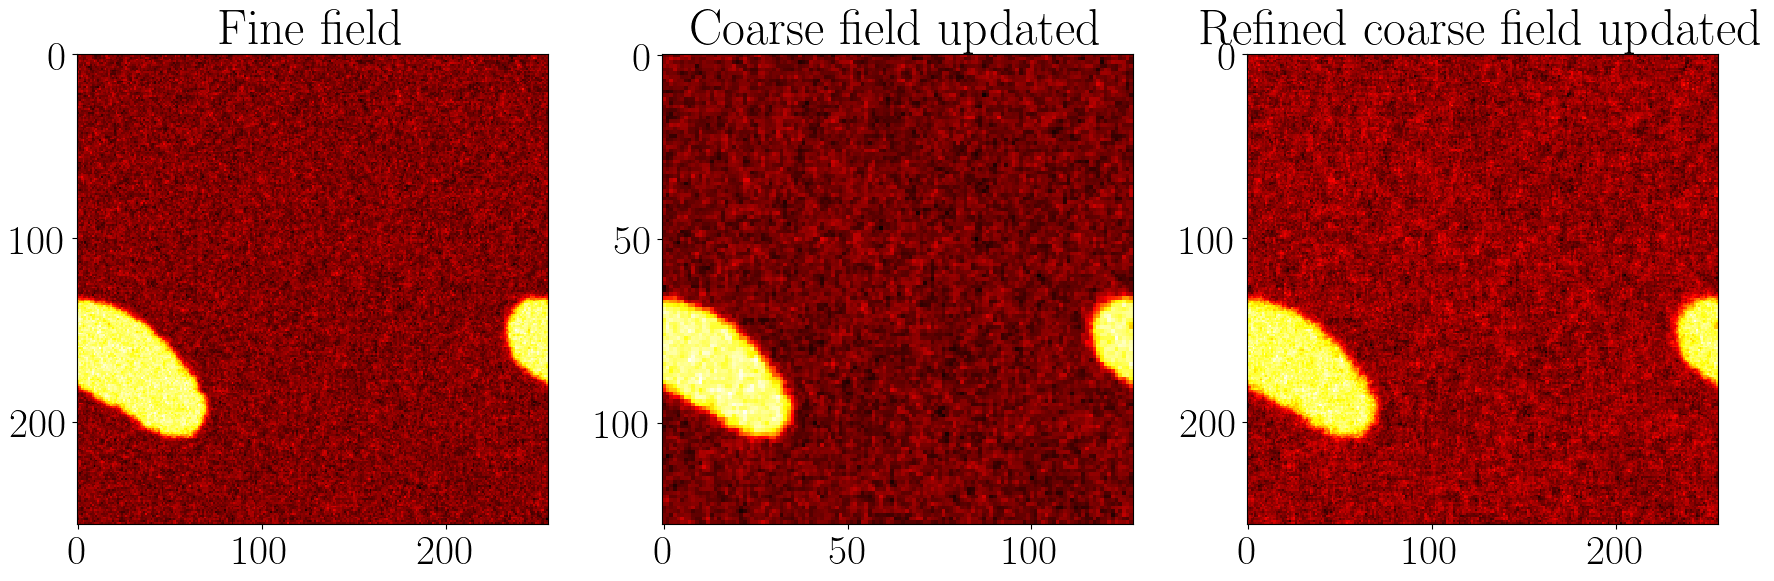

In [ ]:
#define the new lattice and simulate there but starting with the field phi2
L2 = L//2
lat2 = [L2,L2]
sg2 = s.phi4(lat2,lam,mas,batch_size=batch_size,device=device)
#phi2 = sg2.hotStart()
mn2_2 = i.minnorm2(sg2.force,sg2.evolveQ,7,1.0)
phi2 = phi2
print(phi2.shape,Vol//4,tr.mean(phi2),tr.std(phi2))

#mn2 = i.minnorm2(sg.force,sg.evolveQ,7,1.0)
#print(phi.shape,Vol,tr.mean(phi),tr.std(phi))
hmc_2 = u.hmc(T=sg2,I=mn2_2,verbose=False)
phi2 = hmc_2.evolve(phi2,1)

# If we want to come back to the fine lattice
rphi = rg.refine(phi2,pi)
rphi.shape
fig, ax= plt.subplots(1,3, figsize=(18,6))
ax[0].imshow(phi[0,:,:], cmap='hot', interpolation='nearest')
ax[0].set_title(f"Fine field")
ax[1].imshow(phi2[0,:,:], cmap='hot', interpolation='nearest')
ax[1].set_title(f"Coarse field updated")
ax[2].imshow(rphi[0,:,:], cmap='hot', interpolation='nearest')
ax[2].set_title(f"Refined coarse field updated")
plt.show()


This is a naive example of updating but with the wrong distribution. Fortunatelly, this is a linear transformation and the jacobian is 1 from $\psi, \pi \rightarrow \phi$

In [5]:
from phi4_mg import MGflow, FlowBijector, RGlayer

device = "cpu"
print(f"Using {device} device")

L=128

V=L*L
batch_size=4
lam =0.5
mass= -0.2
o  = p.phi4([L,L],lam,mass,batch_size=batch_size)

phi = o.hotStart()

#set up a prior
normal = distributions.Normal(tr.zeros(V),tr.ones(V))
prior= distributions.Independent(normal, 1)

mg = MGflow([L,L],FlowBijector,RGlayer("average"),prior)
#print("The MG module: ",mg)
x = mg(phi)
#print(x)
z,J = mg.backward(x)


print("Test reversibility (must be zero): ",(z-phi).abs().mean().detach().numpy())

z = mg.sample(batch_size)
print(z.shape,x.shape)
J = mg.log_prob(x)
print("the logprobs are: ",J.detach().numpy())


Using cpu device
Initializing MGflow module with size:  128
Using depth:  7
Using rg type:  average
(depth, size):  0 [128, 128]
(depth, size):  1 [64, 64]
(depth, size):  2 [32, 32]
(depth, size):  3 [16, 16]
(depth, size):  4 [8, 8]
(depth, size):  5 [4, 4]
(depth, size):  6 [2, 2]
Test reversibility (must be zero):  1.9628638e-07
torch.Size([4, 128, 128]) torch.Size([4, 128, 128])
the logprobs are:  [-24903.758 -24681.896 -24618.16  -24608.506]


In [13]:
mg.backward(phi)[1]

tensor([-1422.5790, -1435.3324, -1445.6223, -1395.2395],
       grad_fn=<AddBackward0>)